# Load Shape Visualization and Forecasting using XGBoost and Prophet

### By Shahin Karami

This notebook is my introduction to load shapes. I have taken hourly PJM data spanning from January 1, 2002, to August 3, 2018, found via [Kaggle](https://www.kaggle.com/code/robikscube/time-series-forecasting-with-prophet#Data-Cleaning), with the goal of conducting exploratory data analysis on the load shape. This specific data comes from the PJM East region. Unfortunately, neither Kaggle nor PJM's website specifies how they break up their service regions.

The data contains a single column of energy consumption data. Therefore, this project is not representative of what data actually goes into a proper forecast of load shape. External factors like weather and time of year can clearly impact the interpretations one makes within a snapshot of data. Other factors can include holidays, government policies, solar panels, environmental and climate factors, and even macroeconomic factors such as unemployment or CPI. This project does not include any of the external factors mentioned; however, it is important to note the role that these and other external factors can play in this type of data. That said, the purpose of this notebook was to expose me to how one could go about visualizing the energy consumption data and to introduce me to the XGBoost and Prophet models and forecasting using such models.


<hr>

# 1 - Importing Packages and Data

In [217]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import xgboost as xgb
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

##################################################################
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
##################################################################

import warnings
warnings.filterwarnings("ignore")

from pylab import rcParams
rcParams['figure.figsize'] = 16,6

color_pal = sns.color_palette()
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [218]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

# 2 - Exploratory Data Analysis


<hr>

## 2.1 -  Outlier Observations and Basic Visualizations

My starting point is to first look at the descriptive statistics. This provides minimal insight, but once we plot the histogram of the data, we can see some early evidence of outliers and that the data is skewed to the right. This skewness is hinted at by the mean being larger than the 50th percentile.

In [219]:
round(df.describe(), 2).transpose()

count      mean      std      min      25%      50%      75%  \
PJME_MW  145366.0  32080.22  6464.01  14544.0  27573.0  31421.0  35650.0   

             max  
PJME_MW  62009.0

<AxesSubplot:ylabel='Frequency'>

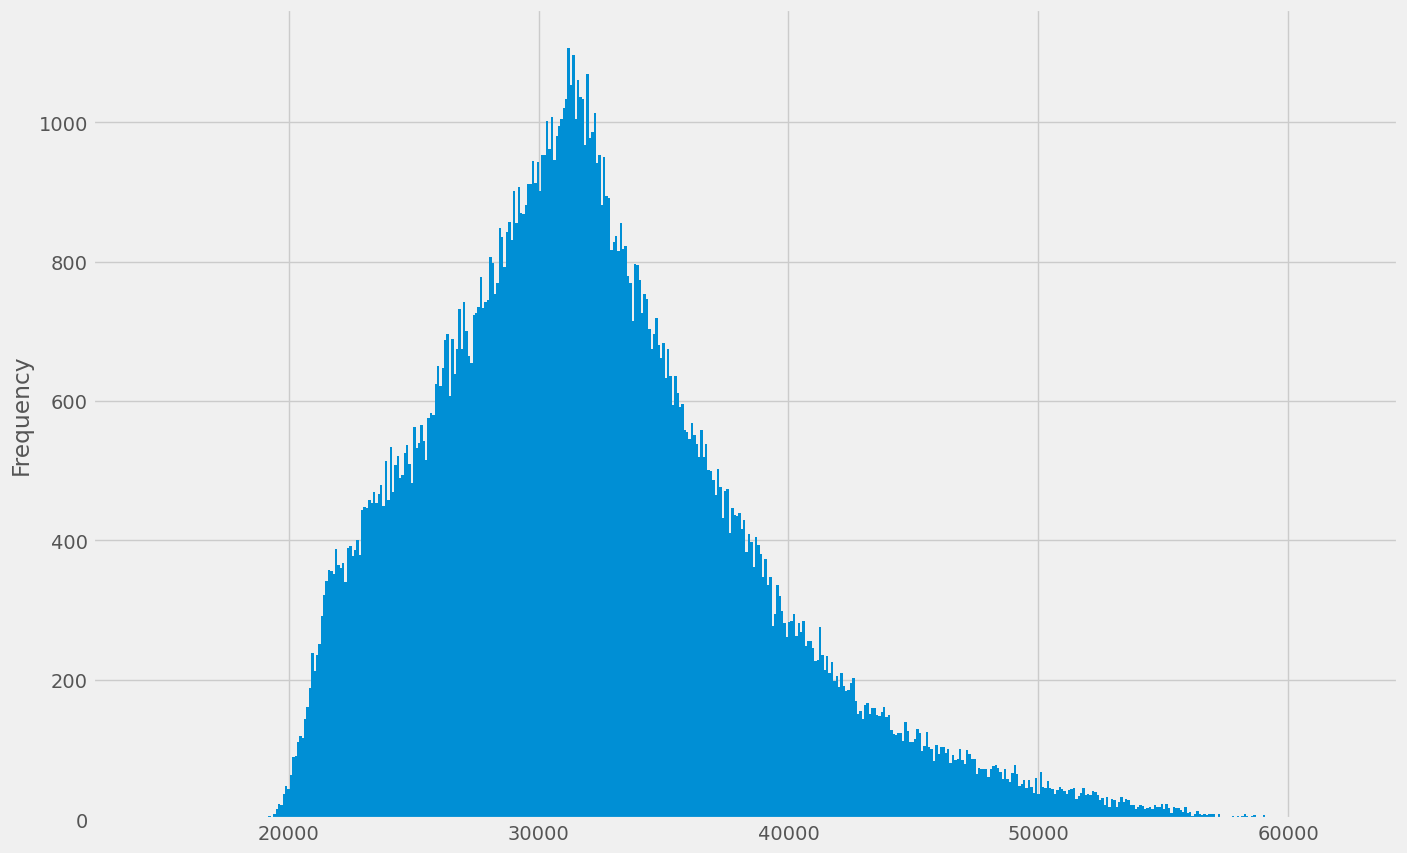

In [220]:
df['PJME_MW'].plot(figsize=(15, 10),kind='hist', bins=500)

Indeed, we see that the histogram is skewed to the right with the mean around 30,000 MW. We are likely to have some outliers above 56,000 or 57,000 MW as well. However, notice that the histogram completely falls off after 20,000 MW. This indicates to me that our data may have a small number of "extreme outliers." These outliers could be due to unusual events. Possible explanations include extreme weather events, partial outages, or even data input errors. Plotting the entire data set will provide more insight.

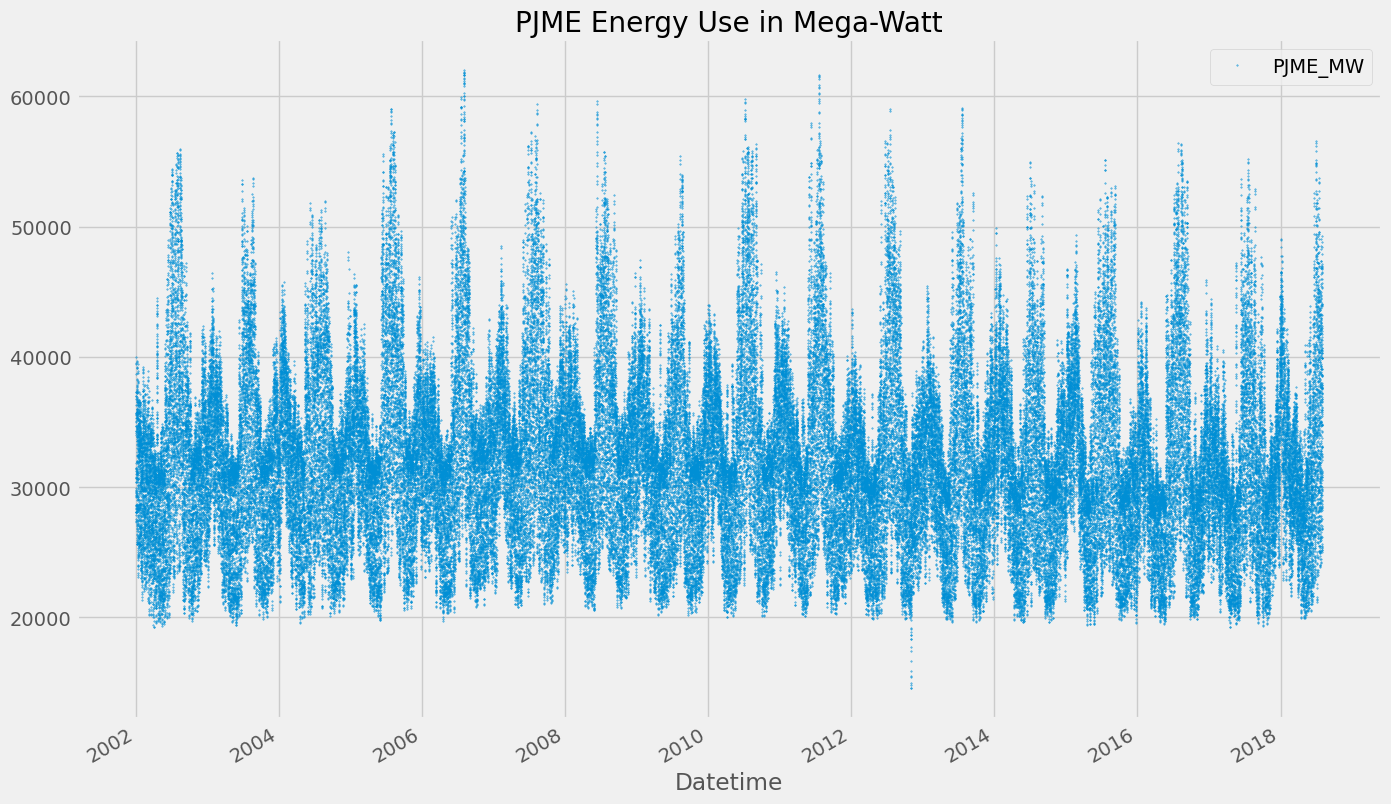

In [221]:
df.plot(style='.', figsize=(15, 10), color=color_pal[0], ms = .75, title='PJME Energy Use in Mega-Watt')
plt.show()


Plotting the entire data and visually inspecting it, there are three notable points to mention:

1) First, there is clear seasonality. The distinct peaks and valleys indicate this. This seasonality is at the yearly level in this plot; however, we will see there are weekly and daily seasonalities to consider as well.

2) The large peaks seen in the plot visually confirm the skewness observed in the histogram above. Visually, they appear to be evenly spaced, which further indicates yearly seasonality. These large peaks in energy consumption likely occurred in the summer months each year.

3) Lastly, we can confirm that some sort of isolated event occurred between 2012 and 2014, which led to extreme outliers below 20,000 MW. Since this is an isolated incident over the 16 years of data, it is worth focusing on data points below the 20,000 MW threshold to gain more insight.

<AxesSubplot:title={'center':'Outliers < 20,000'}, xlabel='Datetime'>

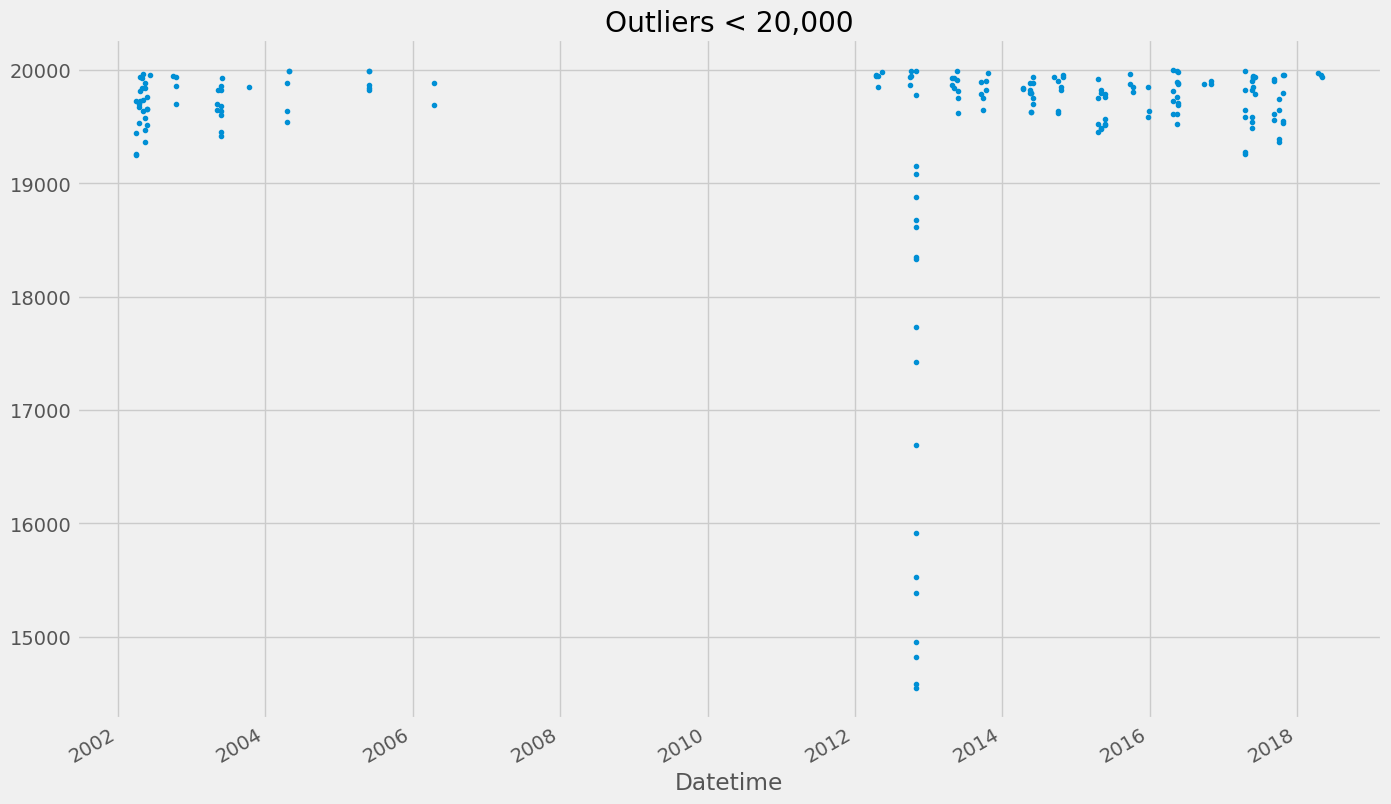

In [222]:
df.query('PJME_MW < 20_000')['PJME_MW'].plot(style='.',figsize=(15, 10),title='Outliers < 20,000')

Focusing on data points under 20,000 MW, while helpful in highlighting how rarely energy consumption falls below this threshold, does not provide any more insight into the behavior of the isolated incident. However, this visual does confirm that plotting values below 19,000 MW will provide the details needed to understand the isolated event.

<AxesSubplot:title={'center':'Outliers'}, xlabel='Datetime'>

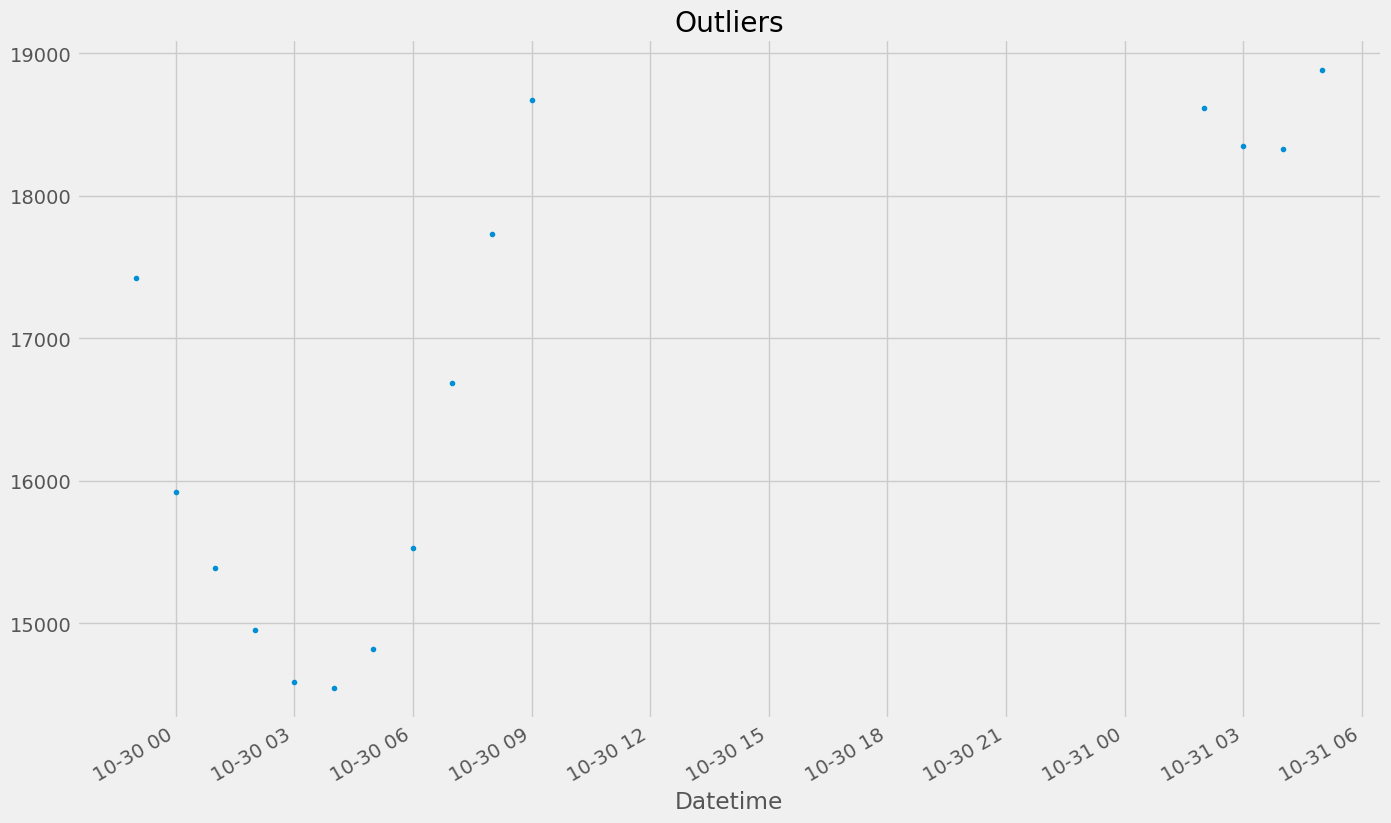

In [223]:
df.query('PJME_MW < 19_000')['PJME_MW'].plot(style='.',figsize=(15, 10),title='Outliers')

Upon inspecting all the sub-19,000 MW data points, it becomes clear that the isolated event occurred over the course of 24 hours in late October 2012. Therefore, we can conclude that the cause of this event was Hurricane Sandy—informally called Superstorm Sandy. Superstorm Sandy made landfall around 8 pm on October 29th. Hence, we can also conclude that the drop in MW consumption was due to the storm's destructive impact. Had there been any major drops prior to the 29th, we might have been able to attribute parts of the energy drop to preventative evacuations that took place in the lead-up to its landfall.

<hr>

## 2.2 - DateTime Feature Creation


To create and analyze the load shape of energy consumption, I will develop a function called `create_features` that provides DateTime-related features. These features will assist in both the analysis of the load shape and in training the XGBoost model. It's important to note that the winter months are included in the feature set.

In [224]:
weekday_cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

month_cat_type = CategoricalDtype(categories=['January', 'February', 
                                              'March', 'April', 'May', 
                                              'June', 'July', 'August', 
                                              'September', 'October', 
                                              'November', 'December'],
                            ordered=True)


def create_features(df, pred = False):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['Date'] = df.index
    df['Hour'] = df['Date'].dt.hour
    df['Day of Week'] = df['Date'].dt.dayofweek
    df['Weekday'] = df['Date'].dt.day_name()
    df['Weekday'] = df['Weekday'].astype(weekday_cat_type)
    df['Month'] = df['Date'].dt.month_name()
    df['Month'] = df['Month'].astype(month_cat_type)
    df['Month of Year'] = df['Date'].dt.month
    df['Quarter'] = df['Date'].dt.quarter
    df['Year'] = df['Date'].dt.year
    df['Day of Year'] = df['Date'].dt.dayofyear
    df['Day of Month'] = df['Date'].dt.day
    df['Week of Year'] = df['Date'].dt.weekofyear
    df['Date_offset'] = (df.Date.dt.month*100 + df.Date.dt.day - 320)%1300

    df['Season'] = pd.cut(df['Date_offset'], [0, 300, 600, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])
    
    if pred == True:
        df = df[['PJME_MW','isFuture','Hour','Day of Week','Quarter','Month','Month of Year','Year',
                 'Day of Year','Day of Month','Week of Year','Weekday', 'Season']]
    if pred == False:
        df = df[['PJME_MW','Hour','Day of Week','Quarter','Month','Month of Year','Year',
                 'Day of Year','Day of Month','Week of Year','Weekday', 'Season']]
    return df



In [225]:
df_features = create_features(df)

In [226]:
df_features.shape # We see that we have 11 more columns. The function worked.

(145366, 12)

<hr>

## 2.3 Detailed Visualization

Detailed visualization is divided into various subsections:

Subsection 2.3.1 consists of Error, Trend, and Seasonality (ETS) decomposition. I perform ETS decomposition at daily, weekly, monthly, and yearly time intervals.

Subsection 2.3.2 involves resampling the load shape at different time intervals to better understand the overall behavior of the data.

Lastly, subsection 2.3.3 examines the load shape of the entire dataset at various time intervals. This section also includes a Seasonal component, allowing for an analysis of the load shape across different seasons.

<hr>

### 2.3.1 Error, Trend, Seasonality (ETS) Decomposition 

The load shapes from the previous subsections suggest the existence of multiple seasonalities at various time intervals. Therefore, the natural approach is to break down the load shape into its components: seasonality, trend, and error. Given the over 140,000 data points, I focus on subsections of the data to illustrate the ETS.

The `seasonal_decompose` function performs a naive decomposition relying on moving averages. As such, its sensitivity can vary based on the window size selected. While `seasonal_decompose` serves the purposes of this notebook, more robust methods such as X11 or STL provide a more desirable decomposition.



#### Daily Seasonality Within a Week Decomposition

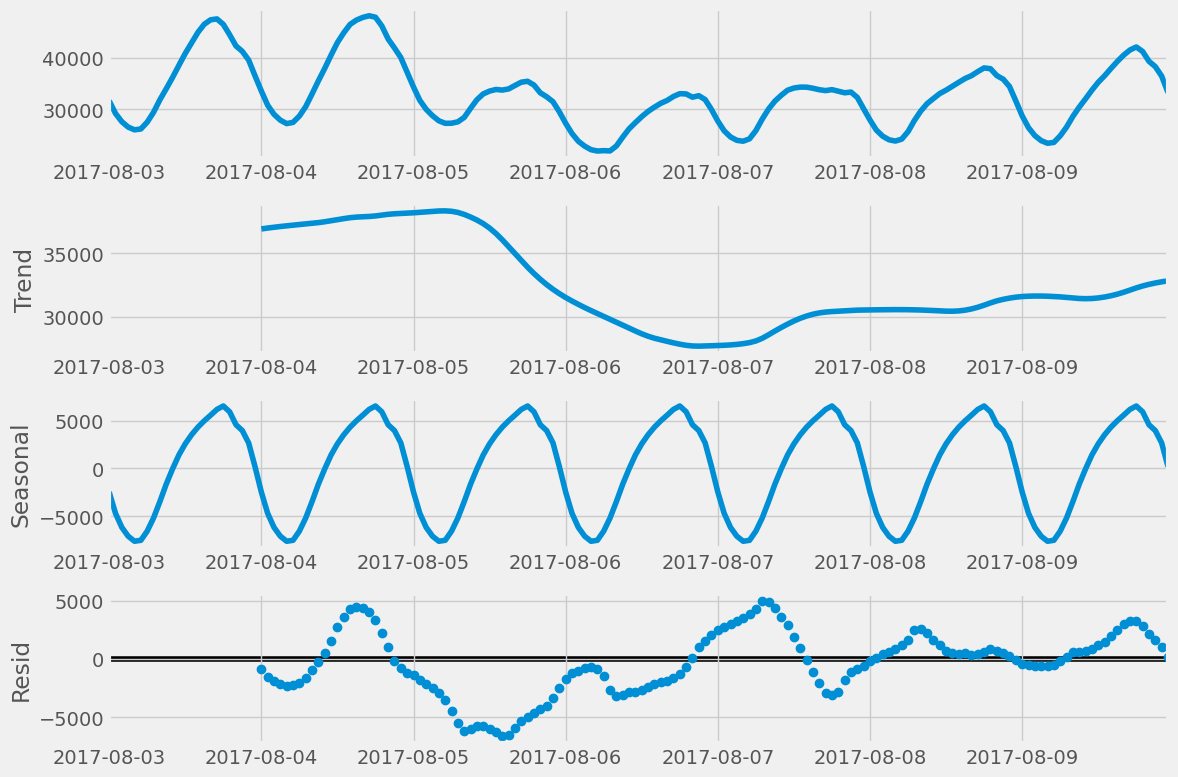

In [227]:
sub = df.loc[(df.index >= '2017-08-03') & (df.index < '2017-08-10')]
#display(sub.head(3))

sub = sub.sort_index()

result = seasonal_decompose(sub, period = 24, model = 'add', two_sided = False)
rcParams['figure.figsize'] = 12,8
fig = result.plot()


#### Weekly Seasonality Within a Single Month

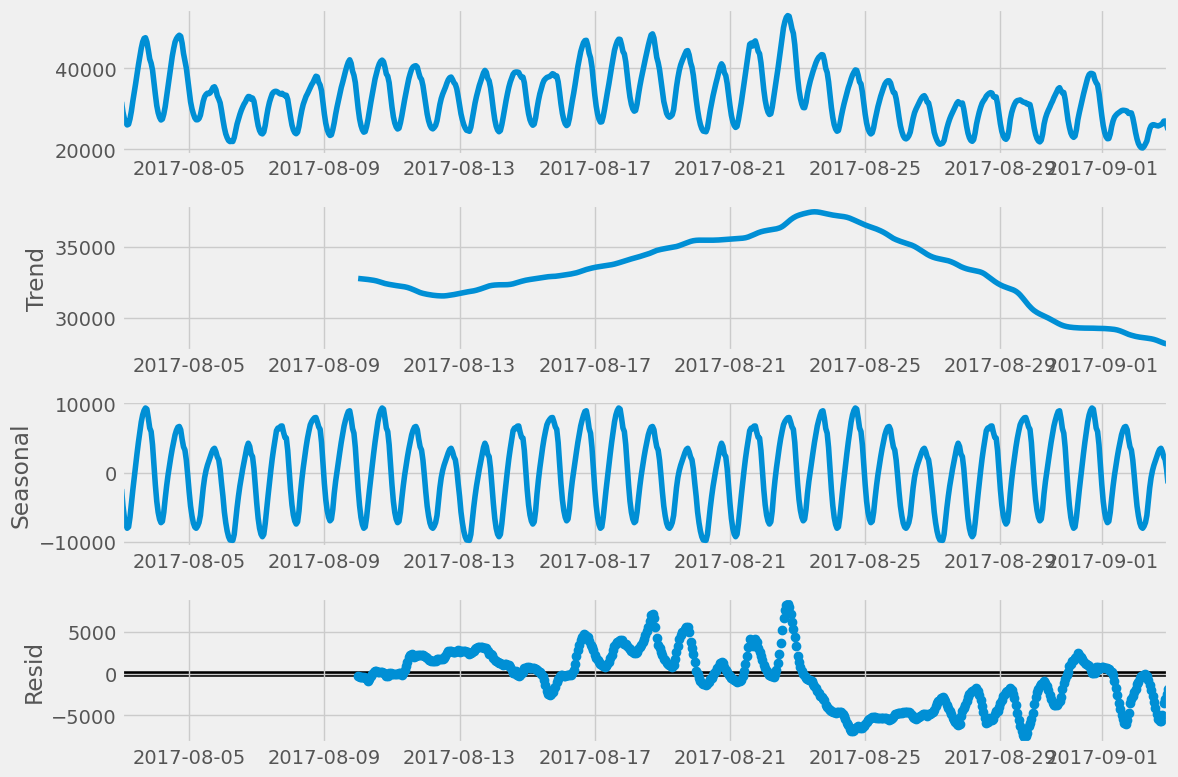

In [228]:
sub = df.loc[(df.index >= '2017-08-03') & (df.index < '2017-09-03')]
#display(sub.head(3))

sub = sub.sort_index()

result = seasonal_decompose(sub, period = 24*7, model = 'add', two_sided = False)
rcParams['figure.figsize'] = 12,8
fig = result.plot()

#### Monthly Seasonality Within a Year

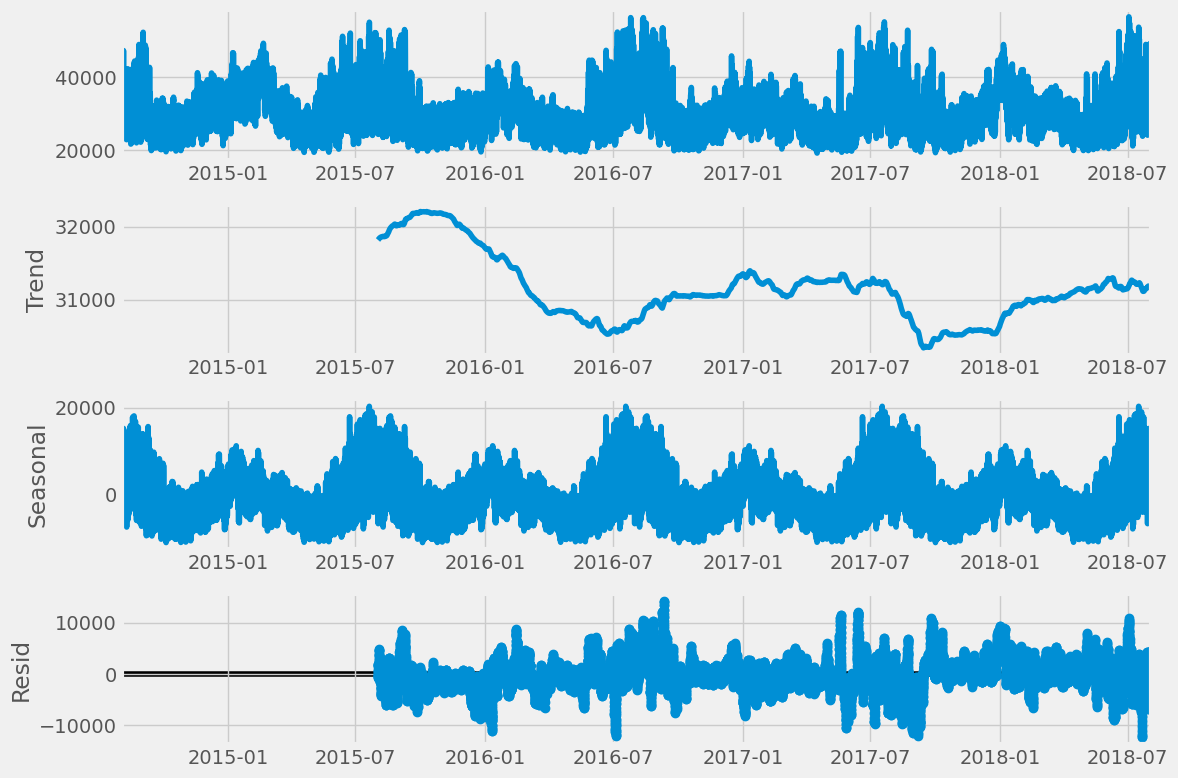

In [229]:
sub = df.loc[(df.index >= '2014-08-03') & (df.index < '2018-08-03')]
#display(sub.head(3))

sub = sub.sort_index()

result = seasonal_decompose(sub, period = 24*7*52, model = 'add', two_sided = False)
rcParams['figure.figsize'] = 12,8
fig = result.plot()


The key takeaway from the combination of these decompositions shown above is that they highlight the existence of different seasonalities and trends across daily, weekly, and monthly intervals.

<hr>

### 2.3.2 Resampled Loadshape


I resample the data from an hourly interval to daily, weekly, and monthly intervals. The purpose of resampling is to reduce granularity, which is useful for both forecasting and visualization. Section 2.3.1 illustrated the presence of different seasonalities. By resampling, we can view the load shape in a simplified and smoother manner.

Datetime
2002-01-01    31080.739130
2002-01-02    34261.541667
2002-01-03    34511.875000
2002-01-04    33715.458333
2002-01-05    30405.125000
Freq: D, Name: PJME_MW, dtype: float64

<AxesSubplot:xlabel='Datetime'>

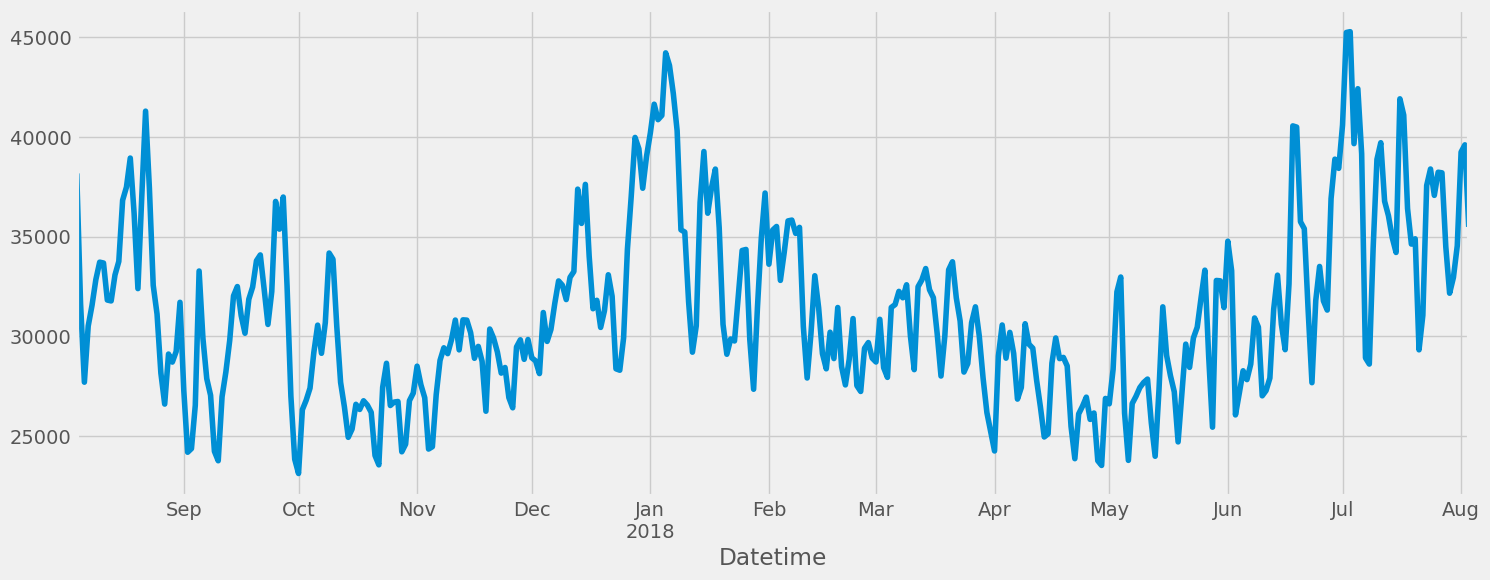

In [230]:
daily_df = df['PJME_MW'].resample('1D').mean()
display(daily_df.head())
rcParams['figure.figsize'] = 16,6
daily_df.loc[daily_df.index > '2017-08-03'].plot()

<AxesSubplot:xlabel='Datetime'>

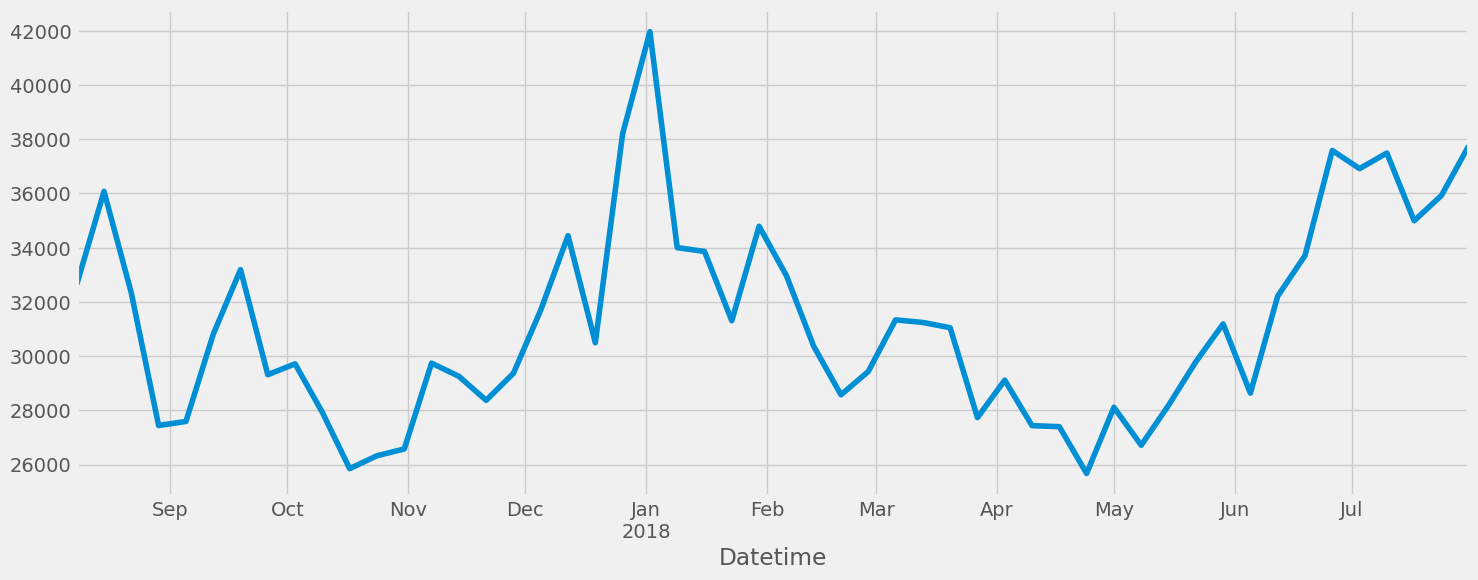

In [231]:
weekly_df = df['PJME_MW'].resample('7D').mean()
rcParams['figure.figsize'] = 16,6
weekly_df.loc[weekly_df.index > '2017-08-03'].plot()

<AxesSubplot:xlabel='Datetime'>

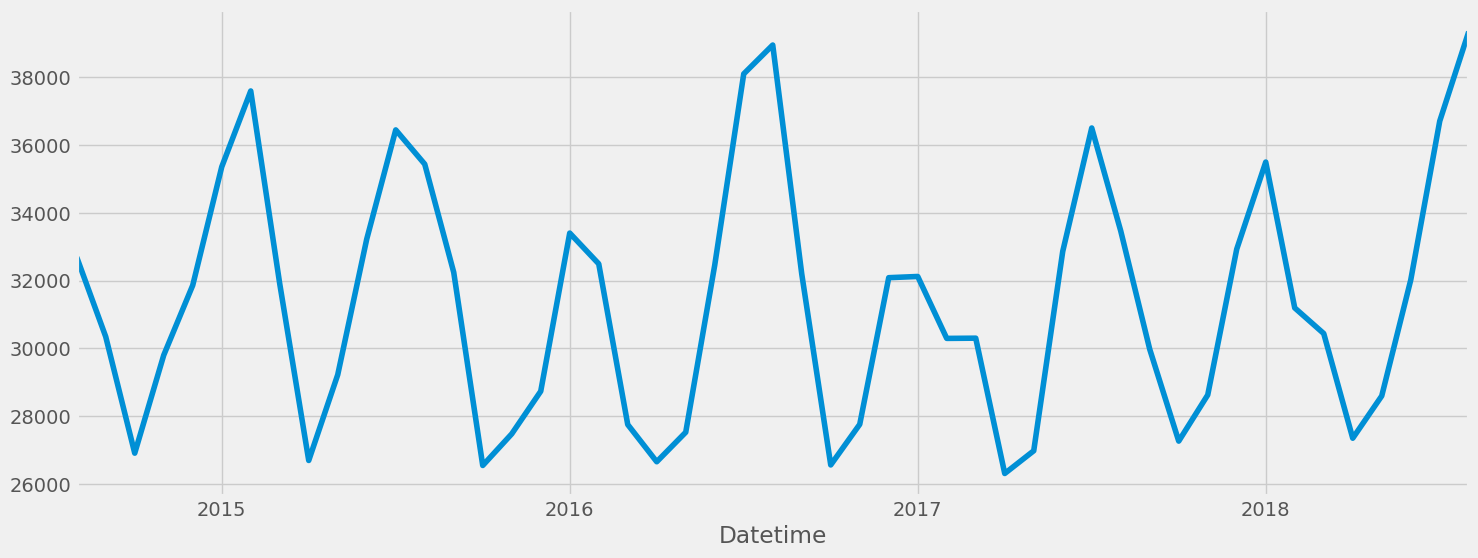

In [232]:
daily_df = df['PJME_MW'].resample('1M').mean()
rcParams['figure.figsize'] = 16,6
daily_df.loc[daily_df.index > '2014-08-03'].plot()

<hr>

### 2.3.3 Aggregate Loadshape

The following four Loadshape plots provide valuable insights into the behavior of the data using only DateTime features created in section 2.2.

Starting with the PJME Daily Trend plot below, there are some interesting observations to note. First, we observe decreased energy consumption from Friday evening (after 18:00) until the beginning of Monday (0:00). Second, the period with the sharpest increase in energy consumption is between 5:00 and 10:00, when most households, businesses, etc., are beginning their day. Energy consumption then increases steadily before a relatively small jump in the early evening. Additionally, we see that on weekends, the same pattern holds, albeit at a reduced level.

<AxesSubplot:title={'center':'PJME Daily Trends'}, xlabel='Hour'>

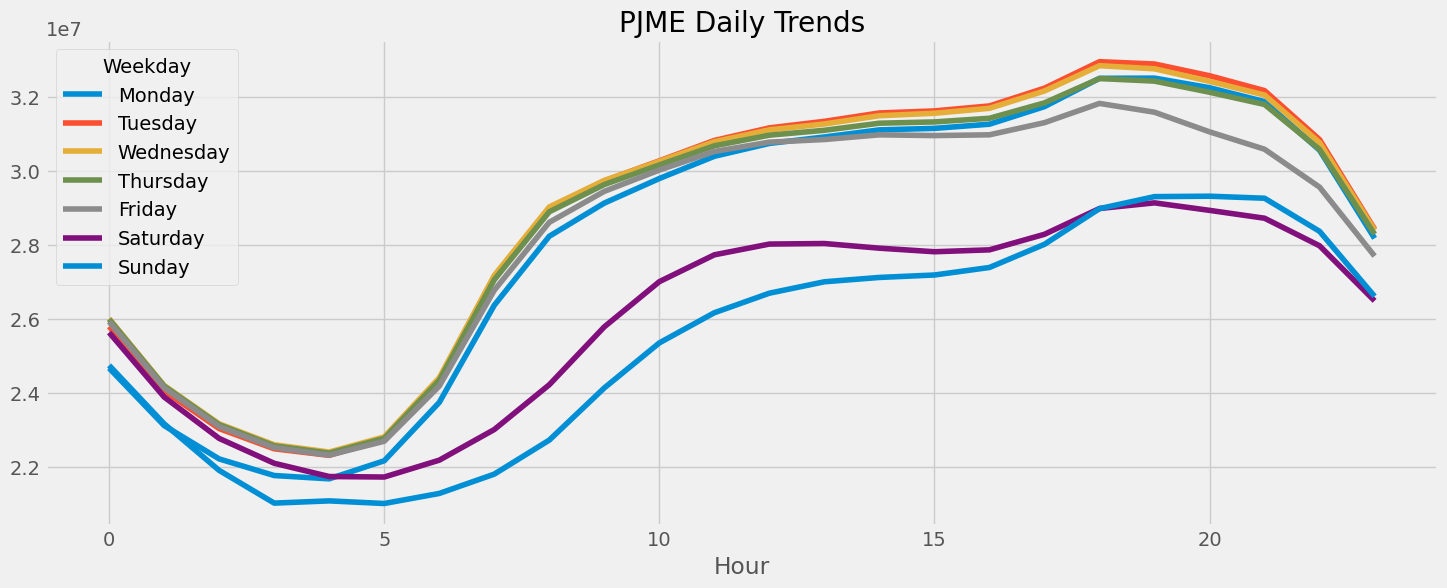

In [233]:
df2 = df_features.pivot_table(index = df_features['Hour'], columns = 'Weekday', values = 'PJME_MW', aggfunc = 'sum')
df2.plot(figsize = (16,6), title = 'PJME Daily Trends')

The next two plots complement each other as they provide additional context to the plot above. First, I focus on the Load Shape grouped by the day of the week and add a `Season` filter to gain better insight into the behavior of the load shape.

The first notable observation is the size of the interquartile range (IQR) between the seasons. Summer exhibits the largest IQR, indicating greater variability in the data during the summer months. This variability can be attributed to the diverse climates of the New England and Mid-Atlantic regions served by PJM. Second, the Fall and Spring seasons share a similar profile in terms of mean, median, and IQR. Both seasons typically experience mild and favorable climates, with Fall generally being warmer than Spring. Therefore, it is natural for these seasons to exhibit similar distributions and overall lower load shapes.

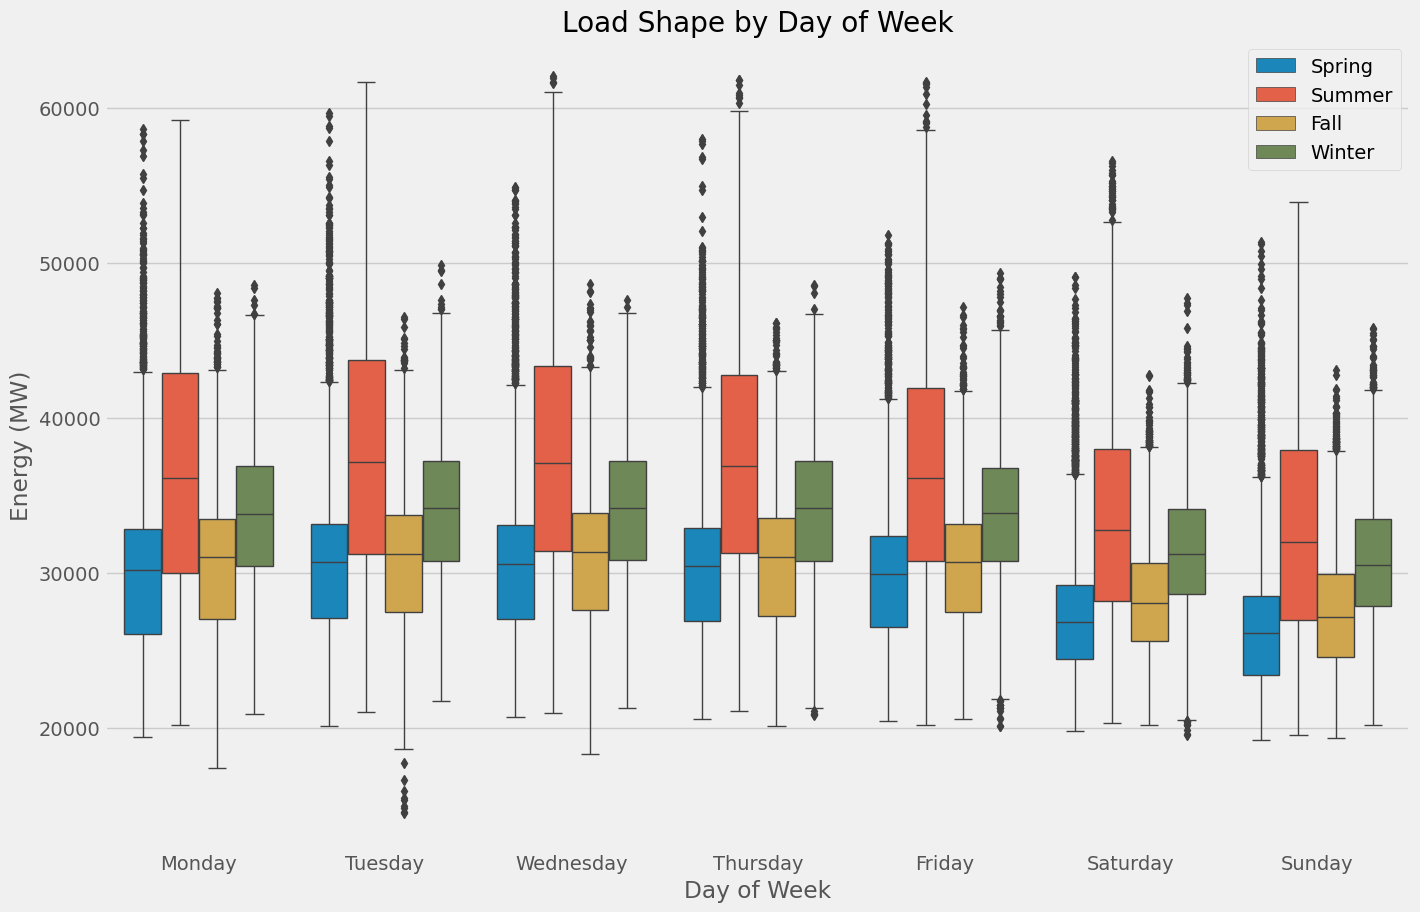

In [234]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=df_features.dropna(),x='Weekday',y='PJME_MW',hue='Season',ax=ax,linewidth=1)

ax.set_title('Load Shape by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

Next, I plot the load shape by hour of the day, again with the season filter applied. Once more, Fall and Spring exhibit almost identical behavior, while Summer and Winter show distinct patterns. Until around 6:00, Winter and Summer exhibit a similar load shape. After 6:00, however, the load shape during the Summer season continues to increase until around 17:00 before steadily decreasing. During this same timeframe, the Winter load shape peaks initially before decreasing to nearly the same level as Spring and Fall. It peaks again at 19:00 before decreasing once more.

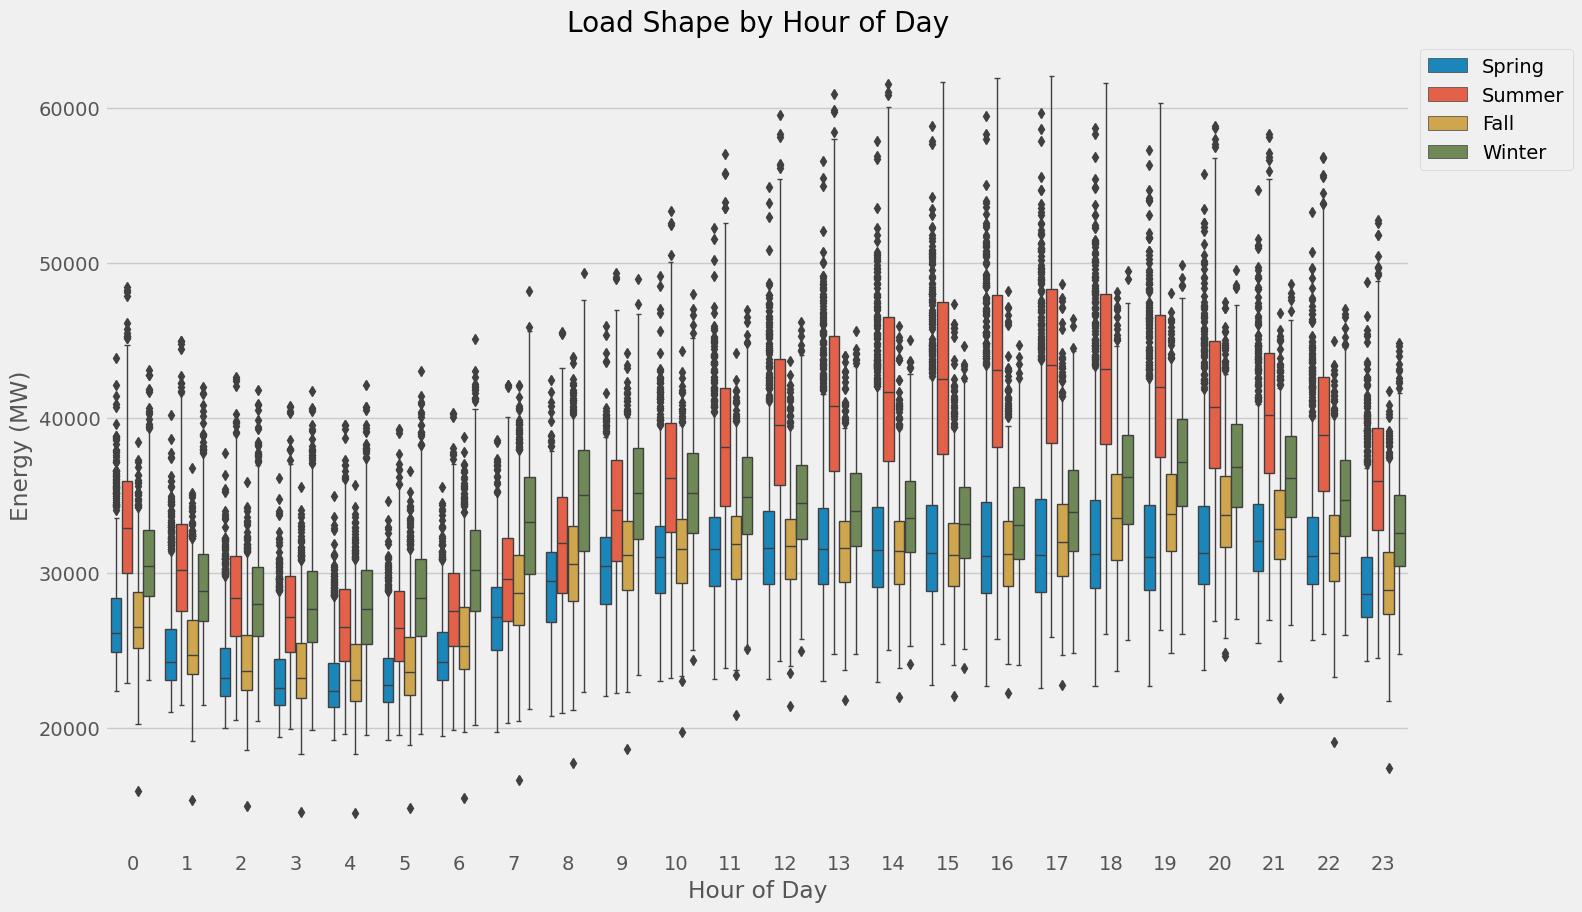

In [235]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=df_features.dropna(),x='Hour',y='PJME_MW',hue='Season',ax=ax,linewidth=1)

ax.set_title('Load Shape by Hour of Day')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

Lastly, I visualize the information from the load shapes above in a different manner. I focus on the months of the year with a `Weekday` filter. We observe that the summer months of June, July, and August show the largest distribution in energy consumption. The Spring and Fall months (March, April, May and September, October, November) exhibit very similar distributions and smaller load shapes. Additionally, within each respective month, Saturdays and Sundays consistently show the tightest and smallest load shapes.

Finally, this visualization provides insight into the behavior of yearly seasonality. Each calendar year, we can expect to see three spikes in energy consumption: one spike at the beginning and end of the calendar year, respectively, and one in the middle of the year around the month of July.



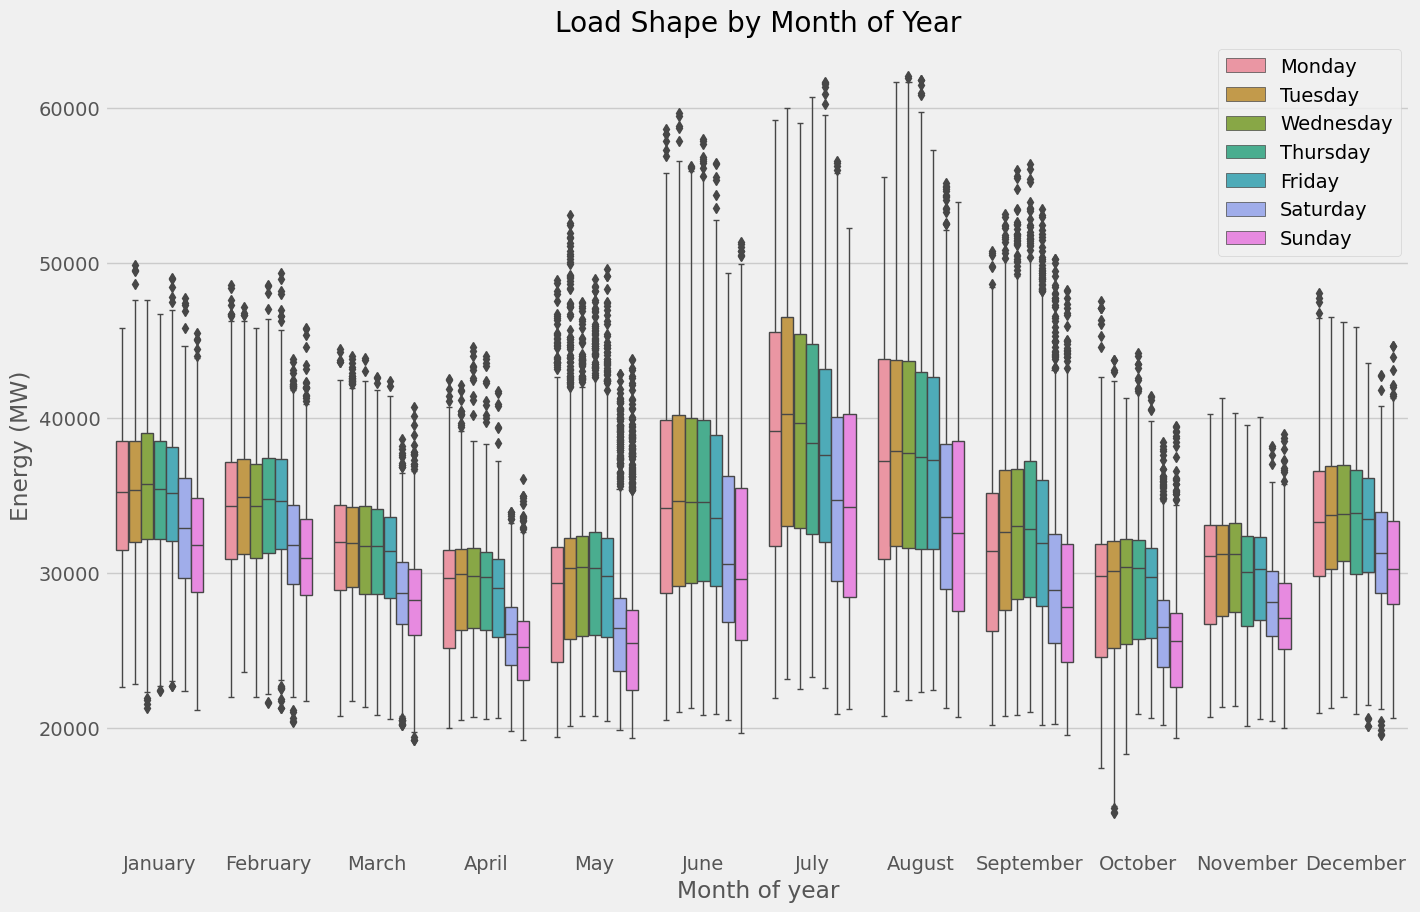

In [236]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=df_features.dropna(),x='Month',y='PJME_MW',hue='Weekday',ax=ax,linewidth=1)

ax.set_title('Load Shape by Month of Year')
ax.set_xlabel('Month of year')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

<hr>

## 3 - Building Machine Learning Models 

In this section, I will create the XGBoost and Prophet models and compare them using multiple metrics such as RMSE and MAPE. Based on these metrics, I will determine which model to use for forecasting. Before creating the XGBoost model, I create and append lag features to the dataframe to enhance the XGBoost model's predictive power.

In [237]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['1 Day Lag'] = (df.index - pd.Timedelta('1 days')).map(target_map) 
    df['2 Day Lag'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['3 Day Lag'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['1 Week Lag'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['2 Week Lag'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['1 Month Lag'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['2 Month Lag'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    df['1 Year Lag'] = (df.index - pd.Timedelta('364 days')).map(target_map) 
    df['2 Year Lag'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    return df

In [238]:
df_features_lags = add_lags(df_features)
df_features_lags.sort_index().head(25)

PJME_MW  Hour  Day of Week  Quarter    Month  \
Datetime                                                            
2002-01-01 01:00:00  30393    1     1            1        January   
2002-01-01 02:00:00  29265    2     1            1        January   
2002-01-01 03:00:00  28357    3     1            1        January   
2002-01-01 04:00:00  27899    4     1            1        January   
2002-01-01 05:00:00  28057    5     1            1        January   
2002-01-01 06:00:00  28654    6     1            1        January   
2002-01-01 07:00:00  29308    7     1            1        January   
2002-01-01 08:00:00  29595    8     1            1        January   
2002-01-01 09:00:00  29943    9     1            1        January   
2002-01-01 10:00:00  30692    10    1            1        January   
2002-01-01 11:00:00  31395    11    1            1        January   
2002-01-01 12:00:00  31496    12    1            1        January   
2002-01-01 13:00:00  31031    13    1            1        January   
2002-01-01 14:00:00  30360    14    1            1        January   
2002-01-01 15:00:00  29798    15    1            1        January   
2002-01-01 16:00:00  29720    16    1            1        January   
2002-01-01 17:00:00  31271    17    1            1        January   
2002-01-01 18:00:00  35103    18    1            1        January   
2002-01-01 19:00:00  35732    19    1            1        January   
2002-01-01 20:00:00  35639    20    1            1        January   
2002-01-01 21:00:00  35285    21    1            1        January   
2002-01-01 22:00:00  34007    22    1            1        January   
2002-01-01 23:00:00  31857    23    1            1        January   
2002-01-02 00:00:00  29563    0     2            1        January   
2002-01-02 01:00:00  28121    1     2            1        January   

                     Month of Year  Year  Day of Year  Day of Month  \
Datetime                                                              
2002-01-01 01:00:00  1              2002  1            1              
2002-01-01 02:00:00  1              2002  1            1              
2002-01-01 03:00:00  1              2002  1            1              
2002-01-01 04:00:00  1              2002  1            1              
2002-01-01 05:00:00  1              2002  1            1              
2002-01-01 06:00:00  1              2002  1            1              
2002-01-01 07:00:00  1              2002  1            1              
2002-01-01 08:00:00  1              2002  1            1              
2002-01-01 09:00:00  1              2002  1            1              
2002-01-01 10:00:00  1              2002  1            1              
2002-01-01 11:00:00  1              2002  1            1              
2002-01-01 12:00:00  1              2002  1            1              
2002-01-01 13:00:00  1              2002  1            1              
2002-01-01 14:00:00  1              2002  1            1              
2002-01-01 15:00:00  1              2002  1            1              
2002-01-01 16:00:00  1              2002  1            1              
2002-01-01 17:00:00  1              2002  1            1              
2002-01-01 18:00:00  1              2002  1            1              
2002-01-01 19:00:00  1              2002  1            1              
2002-01-01 20:00:00  1              2002  1            1              
2002-01-01 21:00:00  1              2002  1            1              
2002-01-01 22:00:00  1              2002  1            1              
2002-01-01 23:00:00  1              2002  1            1              
2002-01-02 00:00:00  1              2002  2            2              
2002-01-02 01:00:00  1              2002  2            2              

                     Week of Year    Weekday  Season  1 Day Lag  2 Day Lag  \
Datetime                                                                     
2002-01-01 01:00:00  1             Tuesday    Winter NaN        NaN          
2002-

###  3.1 Building XGBoost Model & Error Metrics

In [239]:
%%time
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []

RMSEs = []
MAEs = []
MAPEs = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    
    FEATURES = ['Hour', 
                'Day of Week', 
                'Quarter', 
                'Month of Year', 
                'Year',
                'Day of Year', 
                '1 Day Lag', 
                '2 Day Lag', 
                '3 Day Lag', 
                '1 Week Lag', 
                '2 Week Lag',
                '1 Month Lag', 
                '2 Month Lag',
                '1 Year Lag', 
                '2 Year Lag']
    
    TARGET = 'PJME_MW'

    train_feature = create_features(train)
    test_feature = create_features(test)
    train_feature_lags = add_lags(train_feature)
    test_feature_lags = add_lags(test_feature)

    X_train = train_feature_lags[FEATURES]
    y_train = train_feature_lags[TARGET]

    X_test = test_feature_lags[FEATURES]
    y_test = test_feature_lags[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=2000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=250)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    RMSEs.append(RMSE)
    
    MAE = mean_absolute_error(y_test, y_pred)
    MAEs.append(MAE)
    
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    MAPEs.append(MAPE)

[19:53:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32728.09079	validation_1-rmse:31953.94282
[250]	validation_0-rmse:3561.86684	validation_1-rmse:3795.40075
[500]	validation_0-rmse:2220.65509	validation_1-rmse:2599.85098
[750]	validation_0-rmse:2159.96375	validation_1-rmse:2534.30580
[941]	validation_0-rmse:2133.49197	validation_1-rmse:2529.55152
[19:54:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32667.96248	validation_1-rmse:32134.40936
[250]	validation_0-rmse:3573.72161	validation_1-rmse:3779.10111
[500]	validation_0-rmse:2246.27756	validation_1-rmse:2547.23481
[750]	validation_0-rmse:21

#### Visualizing the Actual Values vs Model Prediction Values

I visually compare the the actual values with the predicted values generated by the XGBoost Model. Broadly speaking the model was accurate in predicting the actual values--however the model did not capture all the extreme values. The final Split (Test set) is from 0:00 August 3rd, 2017 to 0:00 August 3rd, 2018.

In [240]:
test['Prediction'] = reg.predict(X_test)

In [241]:
test

PJME_MW    Prediction
Datetime                                  
2017-08-03 01:00:00  29189    28196.464844
2017-08-03 02:00:00  27584    28160.431641
2017-08-03 03:00:00  26544    28114.505859
2017-08-03 04:00:00  26012    28114.505859
2017-08-03 05:00:00  26187    28114.505859
...                    ...             ...
2018-08-02 20:00:00  44057    45564.417969
2018-08-02 21:00:00  43256    44852.136719
2018-08-02 22:00:00  41552    42883.367188
2018-08-02 23:00:00  38500    39957.750000
2018-08-03 00:00:00  35486    36105.062500

[8760 rows x 2 columns]

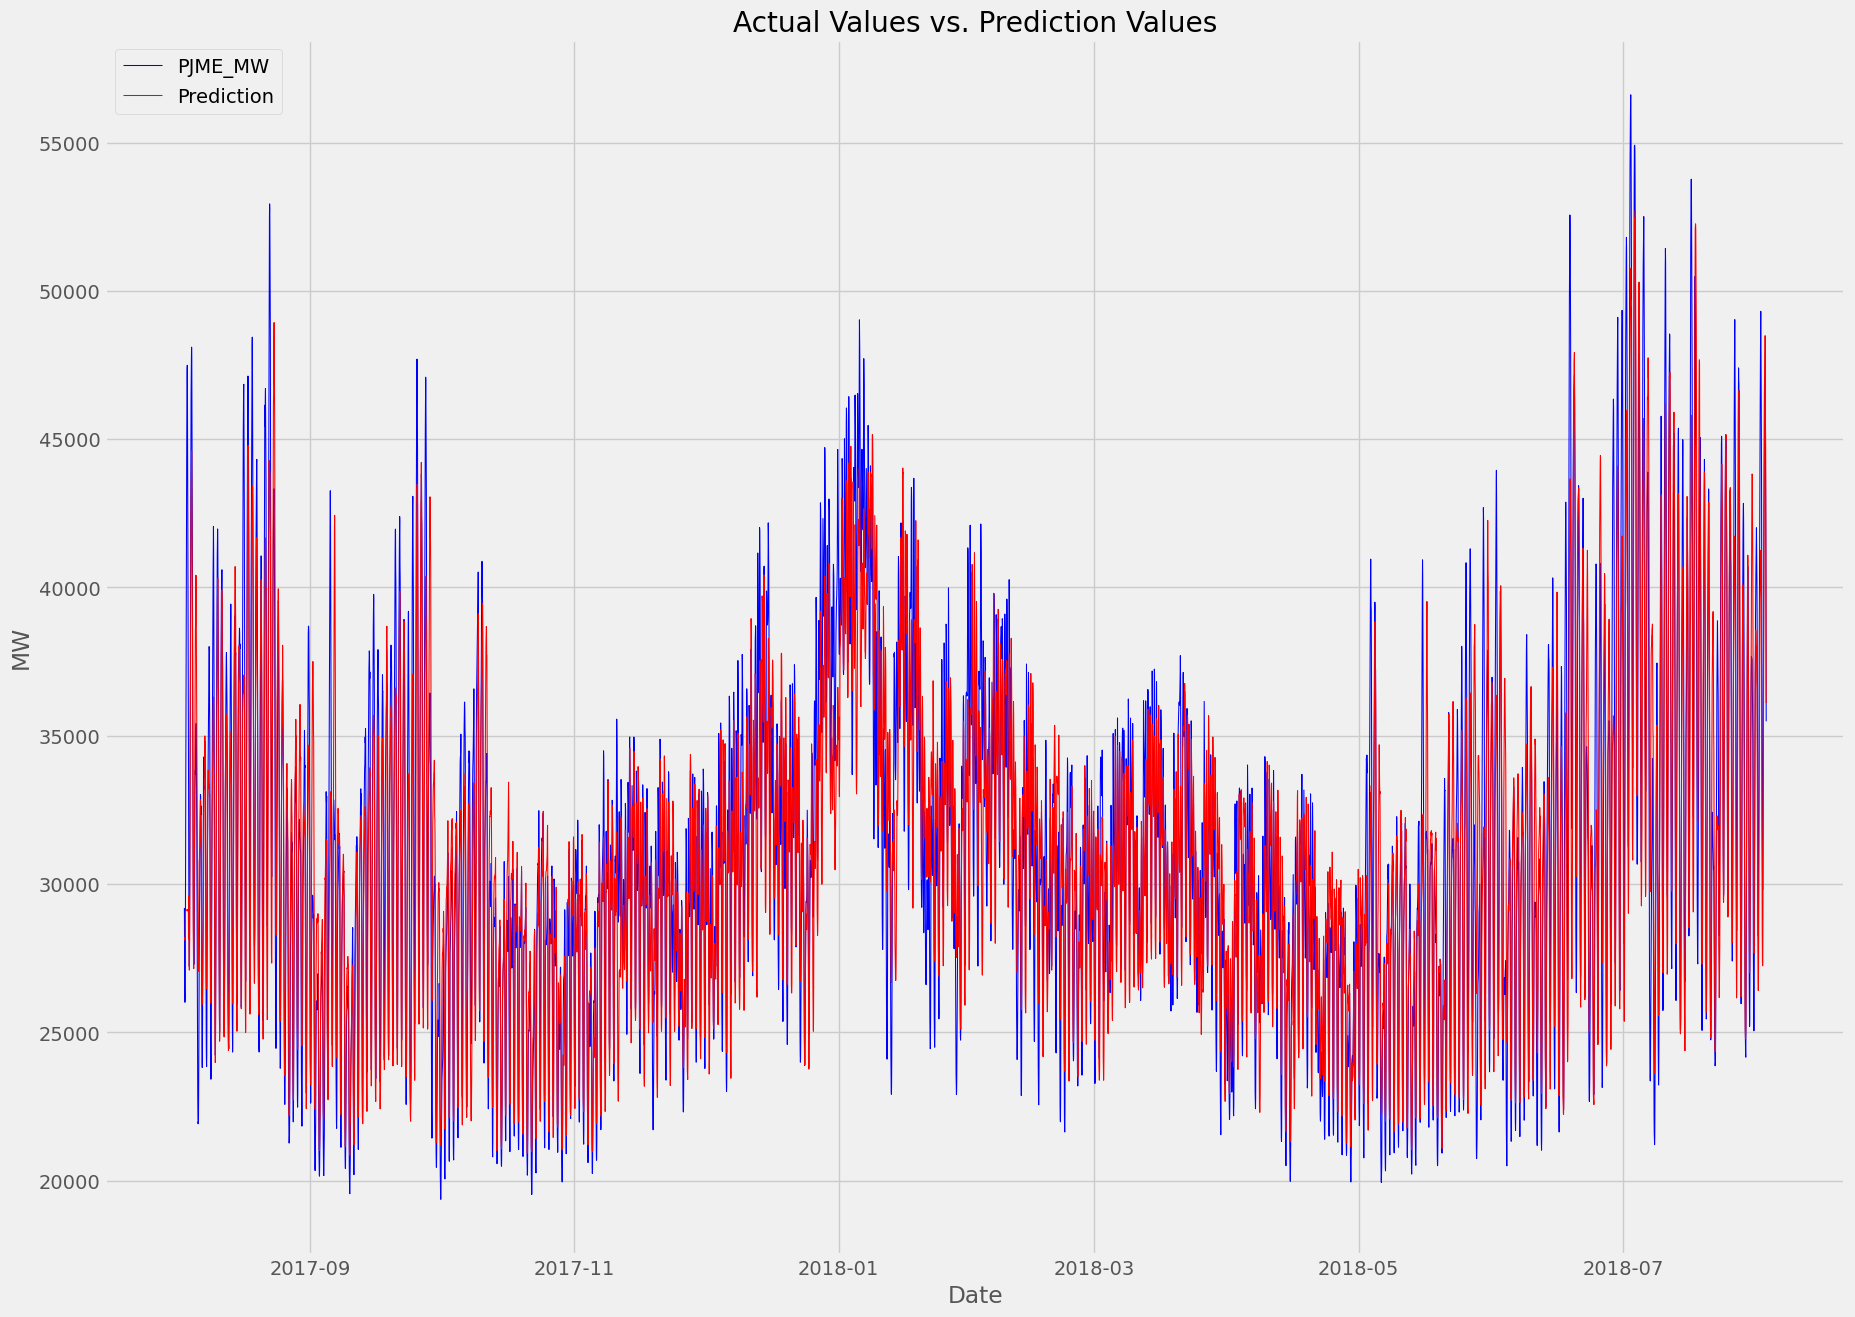

In [242]:
plt.figure(figsize=(20, 15))

plt.plot(test.index, test['PJME_MW'], label='PJME_MW', color='blue', linewidth=.75)
plt.plot(test.index, test['Prediction'], label='Prediction', color='red', linewidth=.75)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('MW')
plt.title('Actual Values vs. Prediction Values')
plt.legend(loc = 2)

# Show the plot
plt.show()


#### RMSE , MAE, and MAPE

The RMSE, MAE, MAPE quantify how well the XGBoost preformed.

In [243]:
# Creating the index column
index_names_XGB = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Fold Avg.']

# Combine the data into a DataFrame
err_met_XGB = {
    'RMSE': RMSEs + [np.mean(RMSEs)],
    'MAE': MAEs + [np.mean(MAEs)],
    'MAPE': MAPEs + [np.mean(MAPEs)]
}

error_metrics_XGB = pd.DataFrame(err_met_XGB, index=index_names_XGB)
error_metrics_XGB

RMSE          MAE      MAPE
Fold 1     2515.869089  1855.553210  5.756074
Fold 2     2481.506432  1851.852938  5.721838
Fold 3     2292.774997  1642.580686  5.206751
Fold 4     2589.021694  1894.215132  5.904566
Fold 5     2679.186741  1967.357072  6.147946
Fold Avg.  2511.671791  1842.311808  5.747435

<hr>

### 3.2 Building Prophet Model and Error Metrics

In [244]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

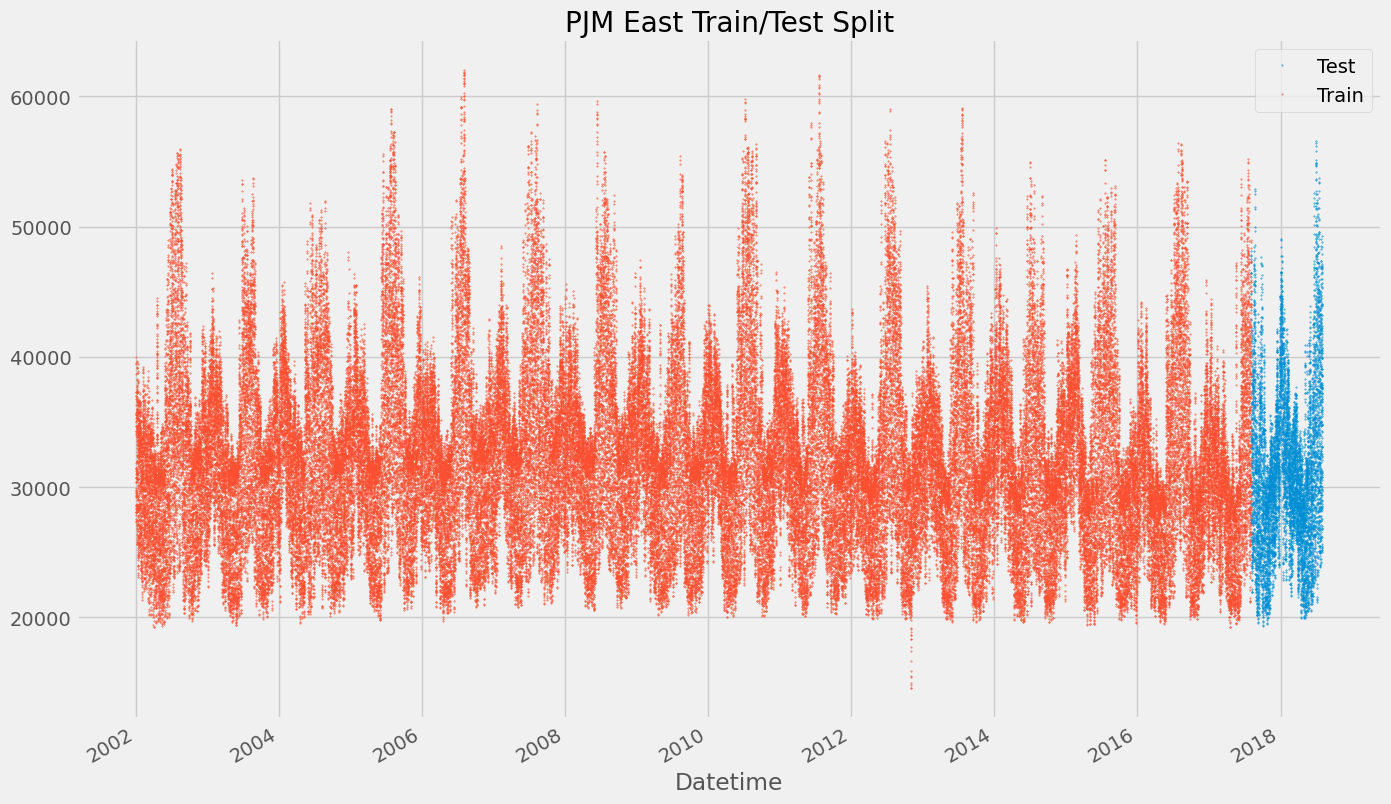

In [245]:
split_date = '3-Aug-2017' # to match the final split of the XGBoost model

df_train = df.loc[df.index < split_date].copy()
df_test = df.loc[df.index >= split_date].copy()

# Plot train and test so you can see where we have split
df_test.rename(columns={'PJME_MW': 'Test'}).join(df_train.rename(columns={'PJME_MW': 'Train'}),
                                                       how='outer').plot(figsize=(15, 10), 
                                                                         title='PJM East Train/Test Split', 
                                                                         style='.', 
                                                                         ms=0.75)

plt.legend()
plt.show()

Prophet modela expect the dataset given to it to be named a specific way. I rename the train and test dataframe columns before feeding it into the model.

* `Datetime` : `ds`
* `PJME_MW` : `y`

In [246]:
df_train_prophet = df_train.reset_index().rename(columns={'Datetime':'ds','PJME_MW':'y'})
df_test_prophet = df_test.reset_index().rename(columns={'Datetime':'ds','PJMW_MW':'y'})

Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training. I will use the built in pandas `USFederalHolidayCalendar` to pull the list of holidays.

In [247]:
cal = calendar() 

holidays = cal.holidays(start=df.index.min(), end = df.index.max(),return_name=True)

holiday_df = pd.DataFrame(data=holidays, columns=['holiday'])

holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})


In [248]:
%%time
model = Prophet(holidays=holiday_df)
model.fit(df_train_prophet)

20:03:53 - cmdstanpy - INFO - Chain [1] start processing
20:05:04 - cmdstanpy - INFO - Chain [1] done processing


Wall time: 1min 28s


In [249]:
model_test_predict = model.predict(df=df_test_prophet)

#### Visualizing the Actual Values vs Model Prediction Values

Below, I plot the actual values against the values predicted by the Prophet model. By using the plot_components method, I can delve deeper into the time series components of the prediction

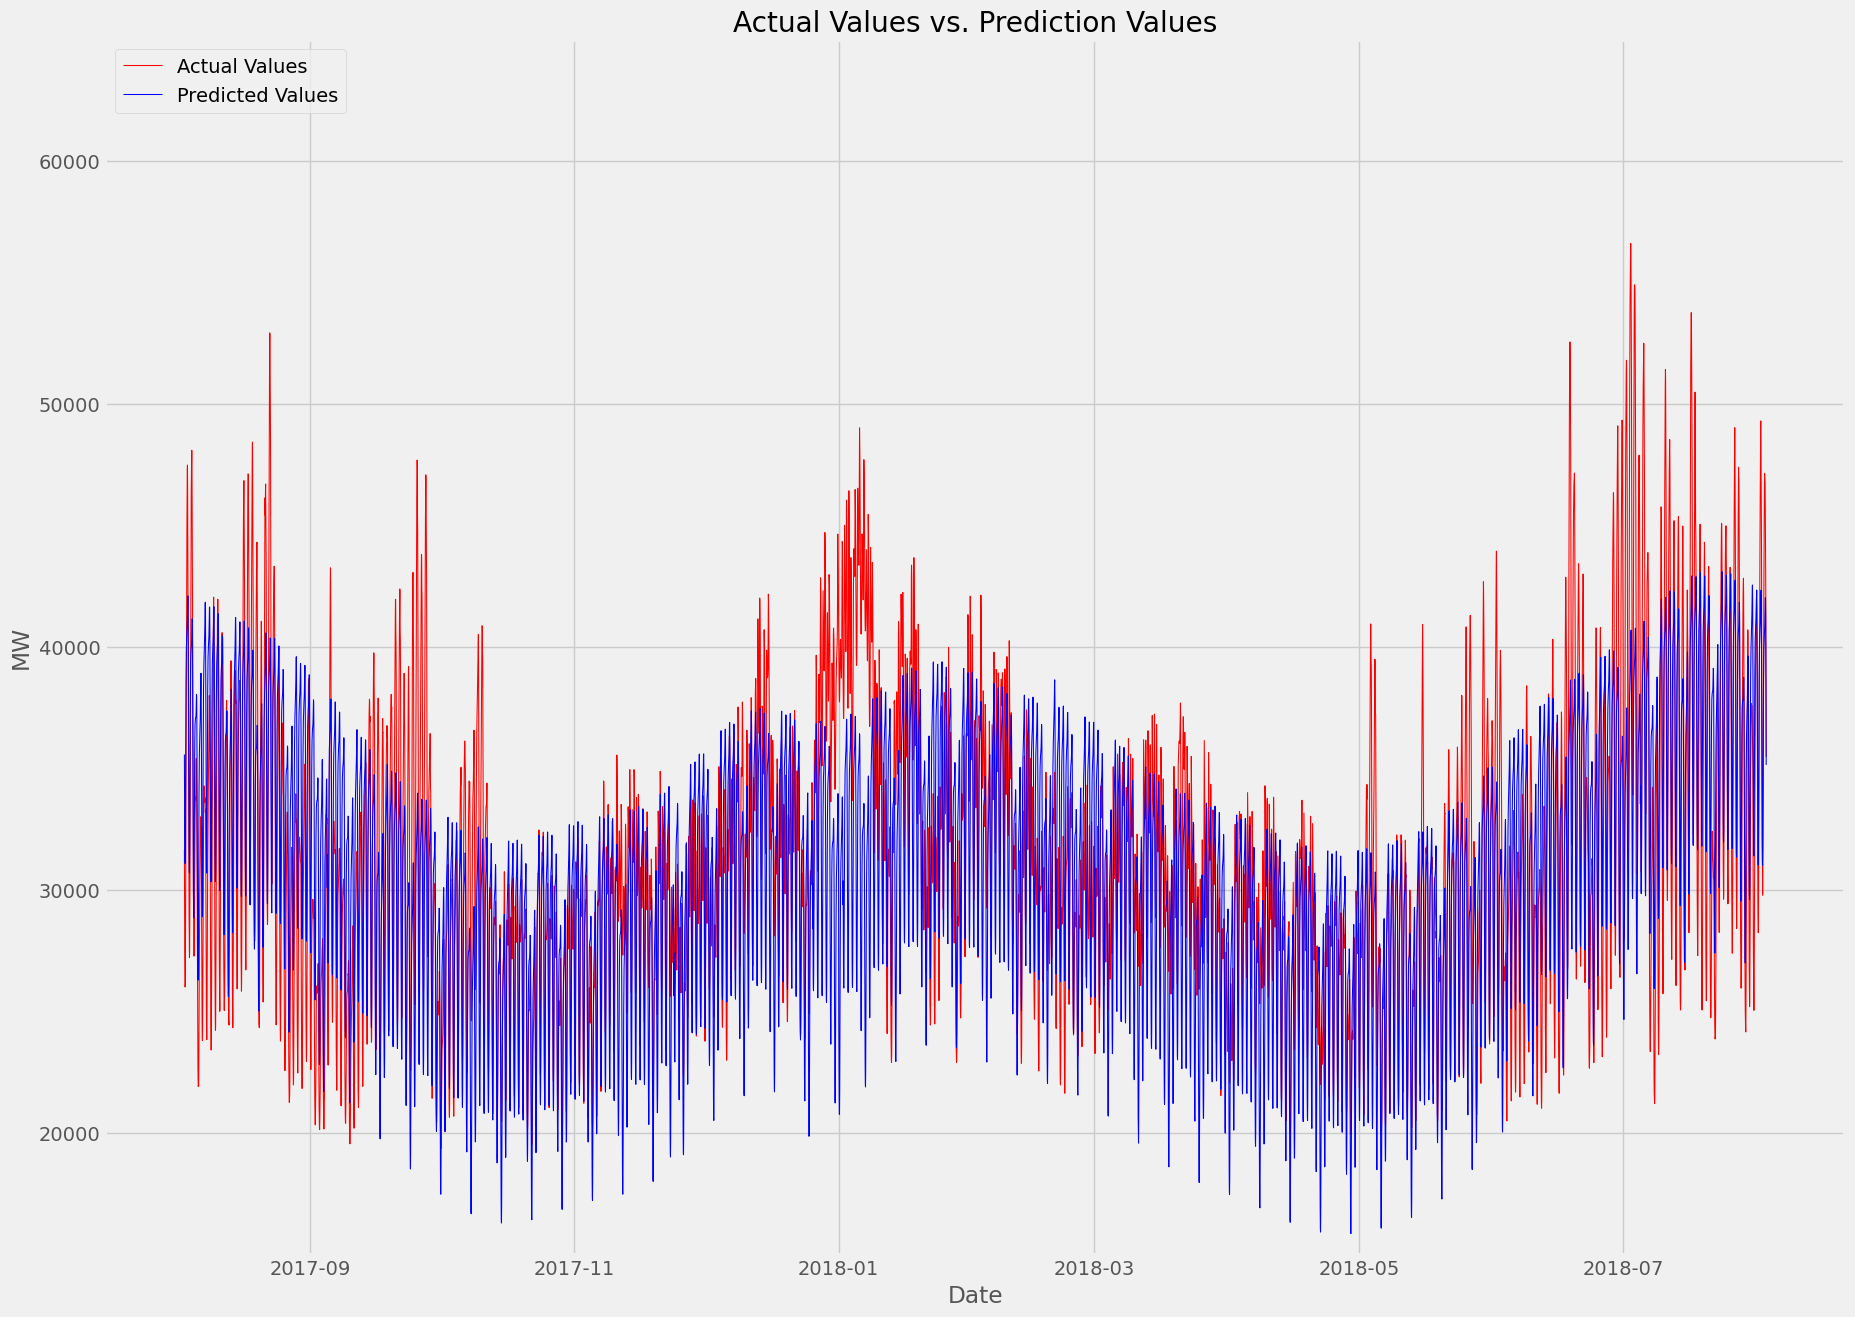

In [250]:
##### df_test = df_test.sort_index()
df_test = df_test[~df_test.index.duplicated(keep='first')]

fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(df_test.index, df_test['PJME_MW'], color='r', label = 'Actual Values',  linewidth=.75)
ax.plot(model_test_predict['ds'], model_test_predict['yhat'], color='b' ,label = 'Predicted Values',  linewidth=.75)

ax.set_xlabel('Date')
ax.set_ylabel('MW')
ax.set_ylim(15000, 65000)
ax.set_title('Actual Values vs. Prediction Values')
ax.legend(loc = 2)


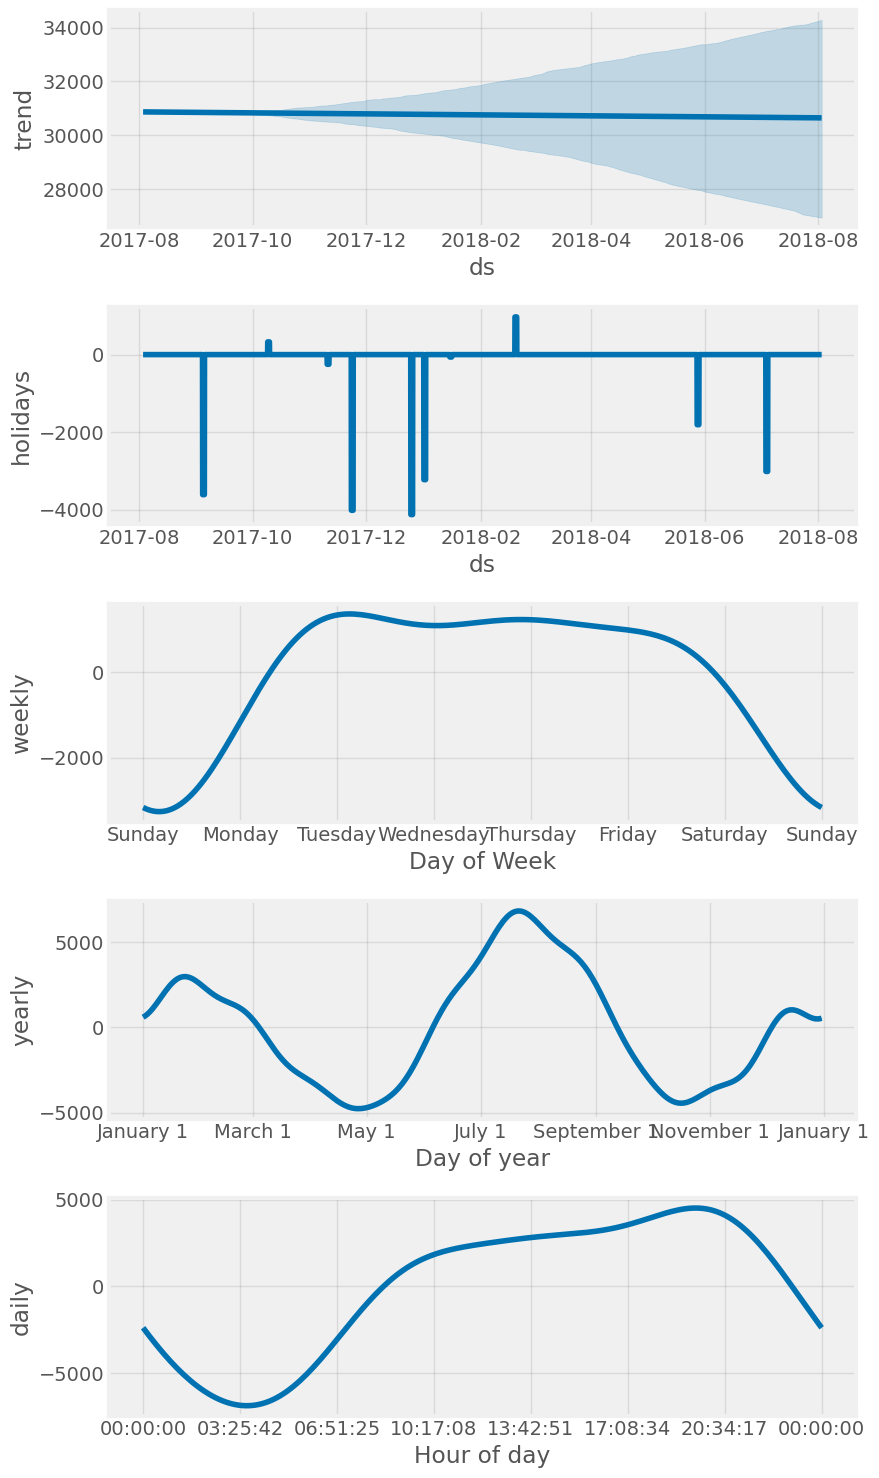

In [251]:
# decomposing the forecast components

model_plot_components = model.plot_components(model_test_predict)

#### Error Metrics 

In [252]:
rmse = np.sqrt(mean_squared_error(y_true=df_test_prophet['PJME_MW'],
                   y_pred=model_test_predict['yhat']))

mae = mean_absolute_error(y_true=df_test_prophet['PJME_MW'],
                   y_pred=model_test_predict['yhat'])

mape = mean_absolute_percentage_error(y_true=df_test_prophet['PJME_MW'],
                   y_pred=model_test_predict['yhat'])


# Creating the index column
index_name = ['Value']

# Combine the data into a DataFrame
err = {
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape
}

error_metrics_Prophet = pd.DataFrame(err, index=index_name)
error_metrics_Prophet



RMSE          MAE       MAPE
Value  4220.192661  3232.729615  10.197939

<hr>

## 4 - Selecting a Model 

Now that the XGBoost and Prophet models have been trained and fitted, I compare the error metrics of both to determine which model to use for predicting future energy consumption. I calulate three different error metrics:

* **RMSE**: Measure the differences between predicted values and actual values. It calculates the square root of the average of the squared differences between predicted and actual values. The RMSE is useful as it penalizes larger errors more than smaller errors. Lower RMSE values indicate better model performance, with a value of 0 indicating a perfect fit

* **MAE**: Calculates the average of the absolute differences between predicted and actual values. Lower MAE values indicate better model performance, with a value of 0 indicating a perfect fit.

* **MAPE**: MAPE is a percentage-based metric that measures the accuracy of predictions relative to the actual values. It calculates the average of the absolute percentage differences between predicted and actual values. The MAPE is commonly used because it’s easy to interpret. For example, a MAPE value of 14% means that the average difference between the forecasted value and the actual value is 14%

#### Error Metrics for XGBoost Model

In [253]:
error_metrics_XGB

RMSE          MAE      MAPE
Fold 1     2515.869089  1855.553210  5.756074
Fold 2     2481.506432  1851.852938  5.721838
Fold 3     2292.774997  1642.580686  5.206751
Fold 4     2589.021694  1894.215132  5.904566
Fold 5     2679.186741  1967.357072  6.147946
Fold Avg.  2511.671791  1842.311808  5.747435

#### Error Metrics for Prophet Model

In [254]:
error_metrics_Prophet

RMSE          MAE       MAPE
Value  4220.192661  3232.729615  10.197939

<hr>

In [255]:
print(f'The Average RMSE, MAE and MAPE for the XGBoost model are: {np.mean(RMSEs):0.4f}, {np.mean(MAEs):0.4f}, and {np.mean(MAPEs):0.2f}% respectively')
print( )
print(f'The RMSE, MAE and MAPE for the Prophet model are: {rmse:0.4f}, {mae:0.4f}, and {mape:0.2f}% respectively')


The Average RMSE, MAE and MAPE for the XGBoost model are: 2511.6718, 1842.3118, and 5.75% respectively

The RMSE, MAE and MAPE for the Prophet model are: 4220.1927, 3232.7296, and 10.20% respectively


Regardless of which metric is used it is clear that the XGBoost model outperforms the current Prophet model. Its important to note that the current Prophet does not utilze any Cross Validation methods. Future iterations of this project will include the Prophet's build-in cross validation method. 

Thus my out of sample prediction will use the XGBoost model.

## 5 -  Out of Sample Prediction using XGBoost

To predict out of sample for 1 year, I will have to rerun the model with some minor tweaks. First, I train on all 
available data. Second I reduce the number of estimators from 2000 down to 1000 as this is the average number of steps our model took above.


Since the earliest lag period usied in training the XGBoost model was the `1 Day Lag`, the out of sample predictions will also be a 1 day. If I wanted to create a realiable out of sample prediction for a week the earliest lag period would be the `1 Week Lag` (Similarly for a 1 Month or 1 Year out of sample prediction). However, the less lagged feature the model is trained with the greater the error metrics will be.    

### 5.1 - Training the Model on Entire Data Set

In [256]:
df_OOS = df.copy()

In [257]:
df_OOS.min()

PJME_MW    14544
dtype: int64

In [258]:
df_OOS = df_OOS.sort_index()
df_OOS = create_features(df_OOS)
df_OOS = add_lags(df_OOS)

In [259]:
df_OOS

PJME_MW  Hour  Day of Week  Quarter    Month  \
Datetime                                                            
2002-01-01 01:00:00  30393    1     1            1        January   
2002-01-01 02:00:00  29265    2     1            1        January   
2002-01-01 03:00:00  28357    3     1            1        January   
2002-01-01 04:00:00  27899    4     1            1        January   
2002-01-01 05:00:00  28057    5     1            1        January   
...                    ...   ..    ..           ..            ...   
2018-08-02 20:00:00  44057    20    3            3        August    
2018-08-02 21:00:00  43256    21    3            3        August    
2018-08-02 22:00:00  41552    22    3            3        August    
2018-08-02 23:00:00  38500    23    3            3        August    
2018-08-03 00:00:00  35486    0     4            3        August    

                     Month of Year  Year  Day of Year  Day of Month  \
Datetime                                                              
2002-01-01 01:00:00  1              2002  1            1              
2002-01-01 02:00:00  1              2002  1            1              
2002-01-01 03:00:00  1              2002  1            1              
2002-01-01 04:00:00  1              2002  1            1              
2002-01-01 05:00:00  1              2002  1            1              
...                 ..               ... ..           ..              
2018-08-02 20:00:00  8              2018  214          2              
2018-08-02 21:00:00  8              2018  214          2              
2018-08-02 22:00:00  8              2018  214          2              
2018-08-02 23:00:00  8              2018  214          2              
2018-08-03 00:00:00  8              2018  215          3              

                     Week of Year   Weekday  Season  1 Day Lag  2 Day Lag  \
Datetime                                                                    
2002-01-01 01:00:00  1             Tuesday   Winter NaN        NaN          
2002-01-01 02:00:00  1             Tuesday   Winter NaN        NaN          
2002-01-01 03:00:00  1             Tuesday   Winter NaN        NaN          
2002-01-01 04:00:00  1             Tuesday   Winter NaN        NaN          
2002-01-01 05:00:00  1             Tuesday   Winter NaN        NaN          
...                 ..                 ...      ...  ..         ..          
2018-08-02 20:00:00  31            Thursday  Summer  46912.0    40289.0     
2018-08-02 21:00:00  31            Thursday  Summer  45985.0    39938.0     
2018-08-02 22:00:00  31            Thursday  Summer  44094.0    38610.0     
2018-08-02 23:00:00  31            Thursday  Summer  40666.0    35950.0     
2018-08-03 00:00:00  31            Friday    Summer  37158.0    33072.0     

                     3 Day Lag  1 Week Lag  2 Week Lag  1 Month Lag  \
Datetime                                                              
2002-01-01 01:00:00 NaN        NaN         NaN         NaN            
2002-01-01 02:00:00 NaN        NaN         NaN         NaN            
2002-01-01 03:00:00 NaN        NaN         NaN         NaN            
2002-01-01 04:00:00 NaN        NaN         NaN         NaN            
2002-01-01 05:00:00 NaN        NaN         NaN         NaN            
...                  ..         ..          ..          ..            
2018-08-02 20:00:00  36166.0    46337.0     41774.0     49244.0       
2018-08-02 21:00:00  35899.0    44542.0     39779.0     47292.0       
2018-08-02 22:00:00  34879.0    42638.0     38082.0     45506.0       
2018-08-02 23:00:00  32303.0    39276.0     34983.0     42437.0       
2018-08-03 00:00:00  29701.0    35742.0     31740.0     39340.0       

                     2 Month Lag  1 Year Lag  2 Year Lag  
Datetime                                                  
2002-01-01 01:00:00 NaN          NaN         NaN          
2002-01-01 02:00:00 NaN          NaN         NaN          
2002-01-01 03:00:00 NaN          NaN 

In [260]:
%%time

FEATURES = ['Hour', 
            'Day of Week', 
            'Quarter', 
            'Month of Year', 
            'Year',
            'Day of Year', 
            '1 Day Lag', 
            '2 Day Lag', 
            '3 Day Lag', 
            '1 Week Lag', 
            '2 Week Lag',
            '1 Month Lag', 
            '2 Month Lag',
            '1 Year Lag', 
            '2 Year Lag']
    
TARGET = 'PJME_MW'

X_all = df_OOS[FEATURES]
y_all = df_OOS[TARGET]

reg_all = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1500,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
reg_all.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[20:05:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32458.20402	validation_1-rmse:31464.07077
[100]	validation_0-rmse:12155.04746	validation_1-rmse:11737.68476
[200]	validation_0-rmse:5008.87879	validation_1-rmse:5088.47380
[300]	validation_0-rmse:2851.67170	validation_1-rmse:3218.34425
[400]	validation_0-rmse:2373.01348	validation_1-rmse:2820.77840
[500]	validation_0-rmse:2271.00253	validation_1-rmse:2737.47615
[600]	validation_0-rmse:2238.56504	validation_1-rmse:2715.74498
[700]	validation_0-rmse:2219.04275	validation_1-rmse:2707.60108
[800]	validation_0-rmse:2204.68688	validation_1-rmse:2703.15471
[900]	validation_0-rmse:2192.55190	validation_1-rmse:2699.14132
[1000]	validation_0-rmse:2182.78656	validation_1-rmse:2695.44209
[1100]	validation_0-rmse:2172.64174	validation_1-rmse:2689.408

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

### 5.2 - Creating Out of Sample Dataframe

Now I create the skeleton dataframe of our prediction our start date will be the last data point available in our data

In [261]:
df_OOS.sort_index().index.max() # to run find the first date of prediction

Timestamp('2018-08-03 00:00:00')

In [262]:
df_OOS = df_OOS.iloc[:-1 , :]

In [263]:
# Create future dataframe
future = pd.date_range('2018-08-03','2018-08-04', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True

df_OOS['isFuture'] = False
df_and_future = pd.concat([df_OOS, future_df])
df_and_future = create_features(df_and_future, pred = True)
df_and_future = add_lags(df_and_future)

In [264]:
future_w_features = df_and_future.query('isFuture == True').copy()
future_w_features = future_w_features.iloc[:-1 , :]
future_w_features # note that this df has all features but no values for 'PJME_MW'

PJME_MW  isFuture  Hour  Day of Week  Quarter   Month  \
2018-08-03 00:00:00 NaN       True      0     4            3        August   
2018-08-03 01:00:00 NaN       True      1     4            3        August   
2018-08-03 02:00:00 NaN       True      2     4            3        August   
2018-08-03 03:00:00 NaN       True      3     4            3        August   
2018-08-03 04:00:00 NaN       True      4     4            3        August   
2018-08-03 05:00:00 NaN       True      5     4            3        August   
2018-08-03 06:00:00 NaN       True      6     4            3        August   
2018-08-03 07:00:00 NaN       True      7     4            3        August   
2018-08-03 08:00:00 NaN       True      8     4            3        August   
2018-08-03 09:00:00 NaN       True      9     4            3        August   
2018-08-03 10:00:00 NaN       True      10    4            3        August   
2018-08-03 11:00:00 NaN       True      11    4            3        August   
2018-08-03 12:00:00 NaN       True      12    4            3        August   
2018-08-03 13:00:00 NaN       True      13    4            3        August   
2018-08-03 14:00:00 NaN       True      14    4            3        August   
2018-08-03 15:00:00 NaN       True      15    4            3        August   
2018-08-03 16:00:00 NaN       True      16    4            3        August   
2018-08-03 17:00:00 NaN       True      17    4            3        August   
2018-08-03 18:00:00 NaN       True      18    4            3        August   
2018-08-03 19:00:00 NaN       True      19    4            3        August   
2018-08-03 20:00:00 NaN       True      20    4            3        August   
2018-08-03 21:00:00 NaN       True      21    4            3        August   
2018-08-03 22:00:00 NaN       True      22    4            3        August   
2018-08-03 23:00:00 NaN       True      23    4            3        August   

                     Month of Year  Year  Day of Year  Day of Month  \
2018-08-03 00:00:00  8              2018  215          3              
2018-08-03 01:00:00  8              2018  215          3              
2018-08-03 02:00:00  8              2018  215          3              
2018-08-03 03:00:00  8              2018  215          3              
2018-08-03 04:00:00  8              2018  215          3              
2018-08-03 05:00:00  8              2018  215          3              
2018-08-03 06:00:00  8              2018  215          3              
2018-08-03 07:00:00  8              2018  215          3              
2018-08-03 08:00:00  8              2018  215          3              
2018-08-03 09:00:00  8              2018  215          3              
2018-08-03 10:00:00  8              2018  215          3              
2018-08-03 11:00:00  8              2018  215          3              
2018-08-03 12:00:00  8              2018  215          3              
2018-08-03 13:00:00  8              2018  215          3              
2018-08-03 14:00:00  8              2018  215          3              
2018-08-03 15:00:00  8              2018  215          3              
2018-08-03 16:00:00  8              2018  215          3              
2018-08-03 17:00:00  8              2018  215          3              
2018-08-03 18:00:00  8              2018  215          3              
2018-08-03 19:00:00  8              2018  215          3              
2018-08-03 20:00:00  8              2018  215          3              
2018-08-03 21:00:00  8              2018  215          3              
2018-08-03 22:00:00  8              2018  215          3              
2018-08-03 23:00:00  8              2018  215          3              

                     Week of Year Weekday  Season  1 Day Lag  2 Day Lag  \
2018-08-03 00:00:00  31            Friday  Summer  37158.0    33072.0     
2018-08-03 01:00:00  31            Friday  Summer  34283.0    30810.0     
2018-08-03 02:00:00  31            Friday  Summer  32094.0    29409.0

#### Making the Future Prediction

In [265]:
future_w_features['Prediction'] = reg.predict(future_w_features[FEATURES]) # making a prediction usign the features 

<AxesSubplot:title={'center':'MW Consumption Prediction for 8/3/2018'}>

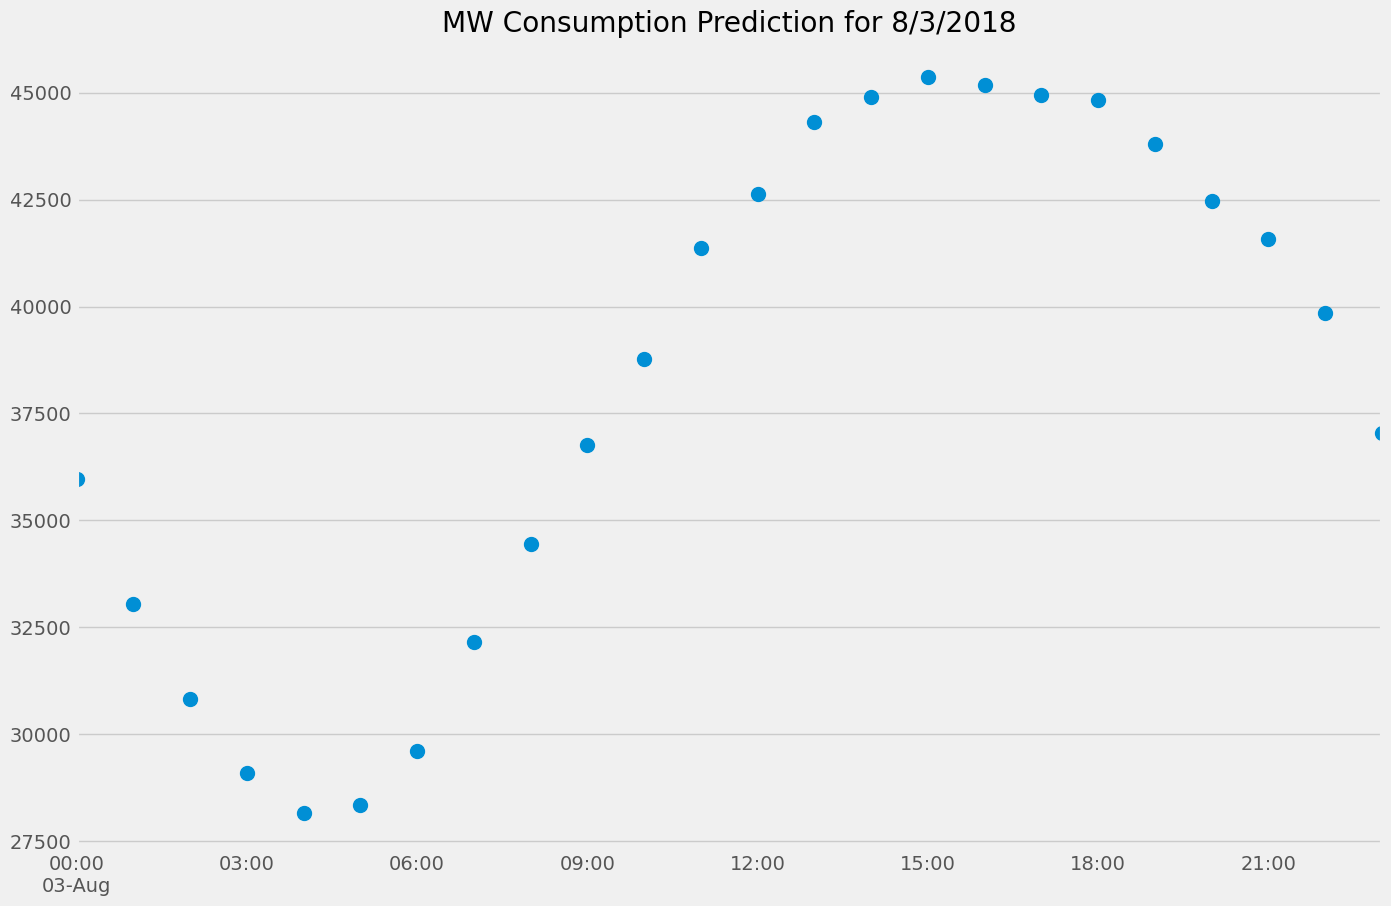

In [266]:
future_w_features['Prediction'].plot(style='.',figsize=(15, 10),ms= 20,title='MW Consumption Prediction for 8/3/2018')

Comparing the out-of-sample prediction plot to the plot of historical power usage in a given day, we see that our prediction visually falls within the interquartile range of what one could expect on a given day in the summer season. Thus I feel confident that the predictions made are reasonable enough.

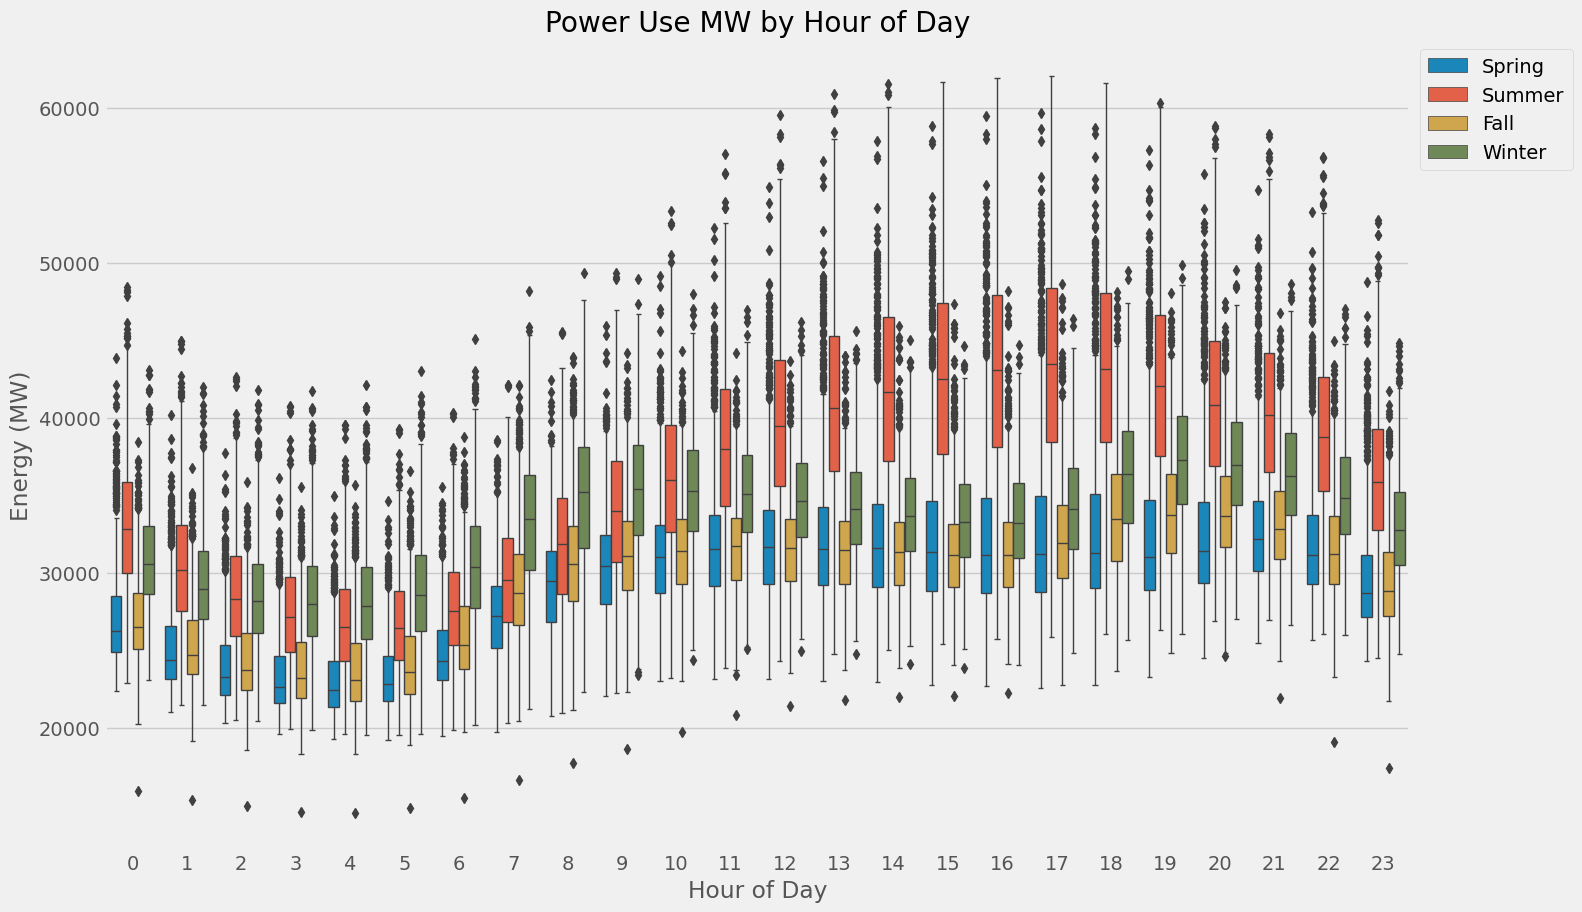

In [267]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=df_features_lags.dropna(), x='Hour', y='PJME_MW', hue='Season',ax=ax, linewidth=1)
ax.set_title('Power Use MW by Hour of Day')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

<hr>

## 6 - Concluding Remarks & Saving the Model

In this project, I used roughly 16 years of PJM energy consumption data to train two different supervised machine learning models—XGBoost and Prophet. After visualizing the data and building the ML models, I used the error metrics RMSE, MAE, and MAPE to determine that the XGBoost model was optimal for out-of-sample prediction. Lastly, I created an out-of-sample prediction for one day, as the earliest lag period used in training the model was a 1-day lag.

Currently, there are two major changes I would consider for future iterations of this project:

1. I would try to understand how the Prophet's cross_validation method works so that I can properly compare the two models.

2. I would also like to incorporate other exogenous regressors into the model. Examples would include weather data (such as whether it rained or snowed at a particular time), temperature data, and calculating moving averages of various regressors.

Lastly I will save the model so I can pick up where I left off when new data is availible to train on.

In [268]:
reg.save_model('xgboost_PJME_MW.json') # now I can call this model directly

Just as proof that the model is saved.

<AxesSubplot:title={'center':'MW Consumption Prediction for 8/3/2018'}>

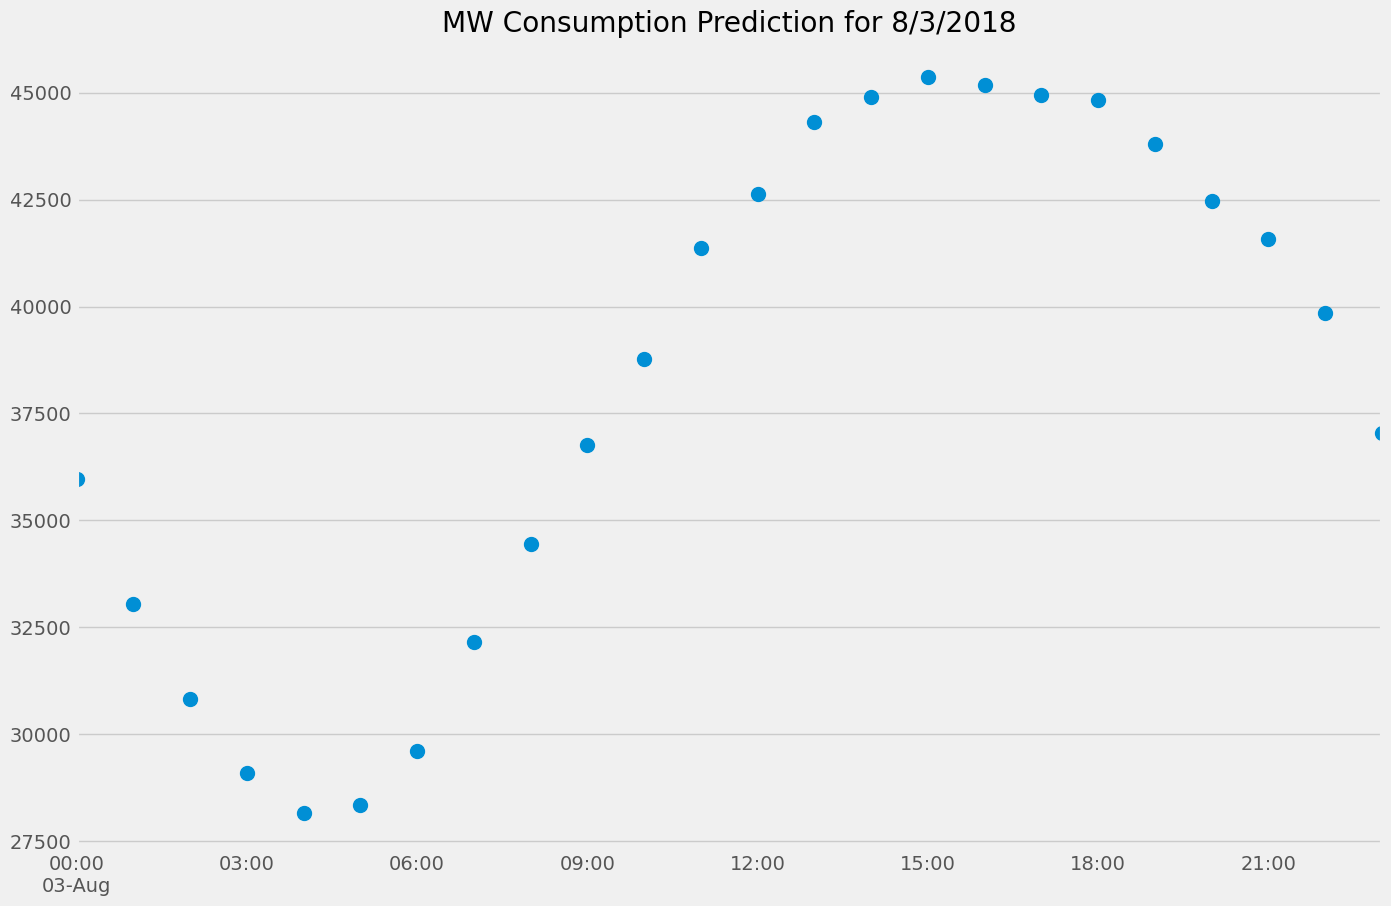

In [269]:
reg_new = xgb.XGBRegressor()

reg_new.load_model('xgboost_PJME_MW.json')

future_w_features['Prediction'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['Prediction'].plot(style = '.',figsize = (15, 10),ms = 20,title='MW Consumption Prediction for 8/3/2018')